In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import wfsc_tests as wfsc
wfsc.math_module.update_np(np)
wfsc.math_module.update_scipy(scipy)

import misc_funs as misc

from hcipy_models import CORO
c = CORO()


In [2]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)


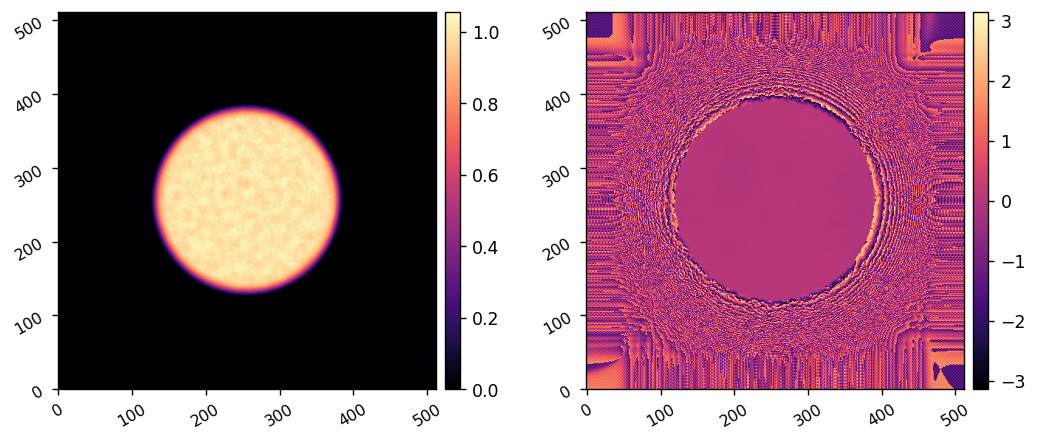

In [3]:
c = CORO(influence_functions=influence_functions,
         dm1_dm2=200*u.mm,
         aberration_distance=500e-3*u.m)

aberrated_pupil = c.wfe_at_distance(hci.Wavefront(c.aperture, c.wavelength.to_value(u.m)))
misc.imshow2(aberrated_pupil.intensity.shaped, aberrated_pupil.phase.shaped)

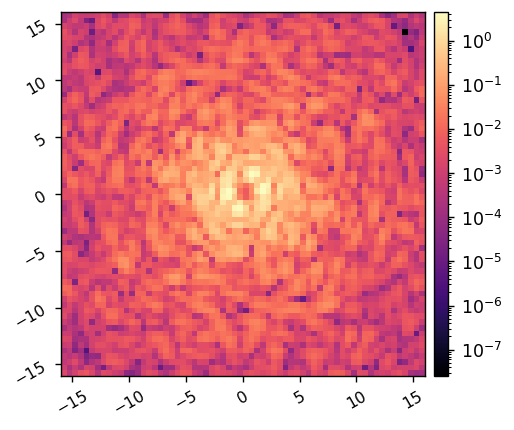

In [4]:
Nact = c.Nact
npsf = c.npsf

c.reset_dms()
ref_im = c.snap()

misc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD)

# define the dark hole region

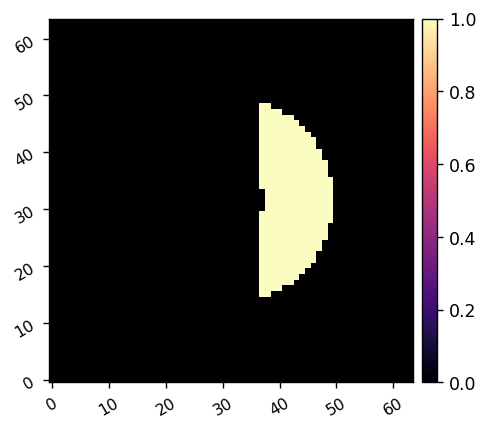

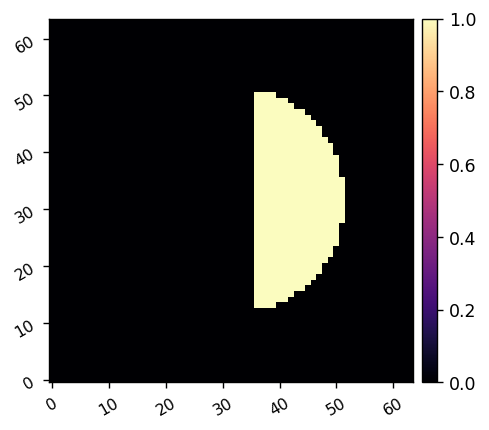

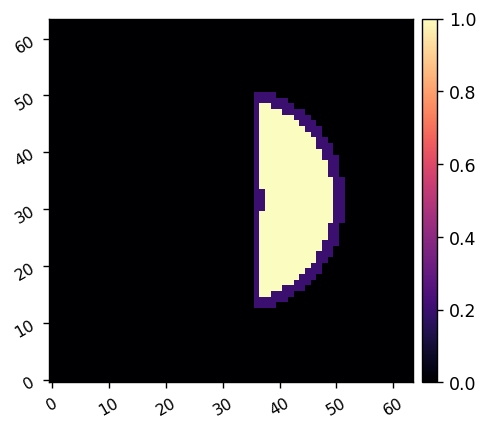

In [5]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)
    
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2.5,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = (3-1)
owa = (9+1)
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
weight_map = roi1 + 0.2*(roi2 * ~roi1)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

probe_amp = 3e-8
calib_amp = 5e-9

(320, 1156)

(160, 2)

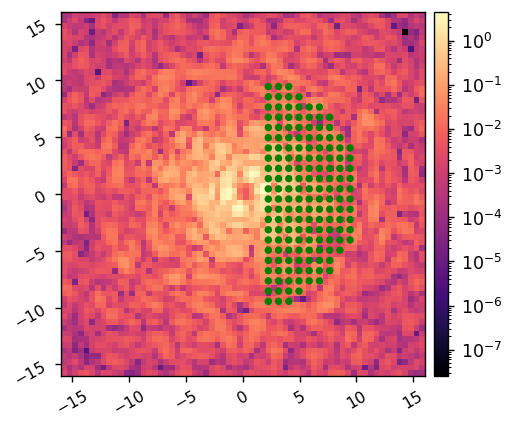

In [6]:
reload(wfsc.imshows)
calib_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.9) 
nmodes = calib_modes.shape[0]
display(calib_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

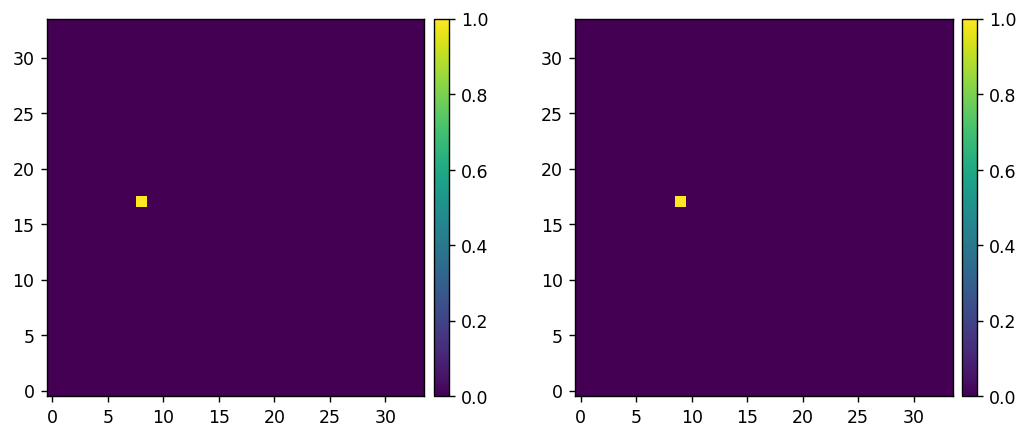

In [8]:
reload(wfsc.utils)
probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//4, Nact//2), (Nact//4+1, Nact//2)], 
                                                 plot=True)

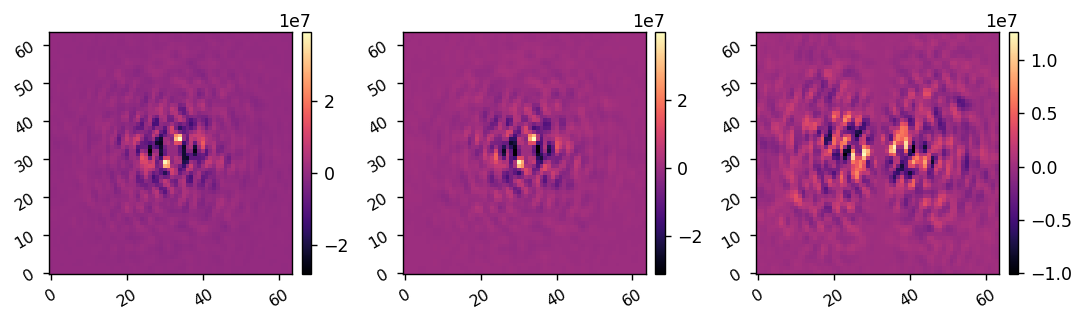

In [9]:
reload(wfsc.iefc)

probe_amp = 3e-8
calib_amp = 5e-9

c.reset_dms()
c.texp = 1
differential_images, single_images = wfsc.iefc_1dm.take_measurement(c, 
                                                           probe_modes, probe_amp, 
                                                           return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
misc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [10]:
reload(wfsc.iefc_1dm)
c.reset_dms()
response_matrix, response_cube = wfsc.iefc_1dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, calib_modes,
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 320 in 1.282s
	Calibrated mode 2 / 320 in 2.561s
	Calibrated mode 3 / 320 in 3.840s
	Calibrated mode 4 / 320 in 5.119s
	Calibrated mode 5 / 320 in 6.400s
	Calibrated mode 6 / 320 in 7.679s
	Calibrated mode 7 / 320 in 8.960s
	Calibrated mode 8 / 320 in 10.240s
	Calibrated mode 9 / 320 in 11.518s
	Calibrated mode 10 / 320 in 12.796s
	Calibrated mode 11 / 320 in 14.074s
	Calibrated mode 12 / 320 in 15.353s
	Calibrated mode 13 / 320 in 16.629s
	Calibrated mode 14 / 320 in 17.905s
	Calibrated mode 15 / 320 in 19.180s
	Calibrated mode 16 / 320 in 20.456s
	Calibrated mode 17 / 320 in 21.733s
	Calibrated mode 18 / 320 in 23.007s
	Calibrated mode 19 / 320 in 24.281s
	Calibrated mode 20 / 320 in 25.555s
	Calibrated mode 21 / 320 in 26.830s
	Calibrated mode 22 / 320 in 28.108s
	Calibrated mode 23 / 320 in 29.383s
	Calibrated mode 24 / 320 in 30.658s
	Calibrated mode 25 / 320 in 31.932s
	Calibrated mode 26 / 320 in 33.205s
	Calibrated mode 27 / 320 in 34.4

	Calibrated mode 216 / 320 in 276.539s
	Calibrated mode 217 / 320 in 277.804s
	Calibrated mode 218 / 320 in 279.069s
	Calibrated mode 219 / 320 in 280.340s
	Calibrated mode 220 / 320 in 281.608s
	Calibrated mode 221 / 320 in 282.880s
	Calibrated mode 222 / 320 in 284.151s
	Calibrated mode 223 / 320 in 285.420s
	Calibrated mode 224 / 320 in 286.689s
	Calibrated mode 225 / 320 in 287.961s
	Calibrated mode 226 / 320 in 289.234s
	Calibrated mode 227 / 320 in 290.506s
	Calibrated mode 228 / 320 in 291.775s
	Calibrated mode 229 / 320 in 293.043s
	Calibrated mode 230 / 320 in 294.312s
	Calibrated mode 231 / 320 in 295.580s
	Calibrated mode 232 / 320 in 296.850s
	Calibrated mode 233 / 320 in 298.121s
	Calibrated mode 234 / 320 in 299.388s
	Calibrated mode 235 / 320 in 300.655s
	Calibrated mode 236 / 320 in 301.919s
	Calibrated mode 237 / 320 in 303.187s
	Calibrated mode 238 / 320 in 304.458s
	Calibrated mode 239 / 320 in 305.726s
	Calibrated mode 240 / 320 in 306.989s
	Calibrated mode 241 / 32

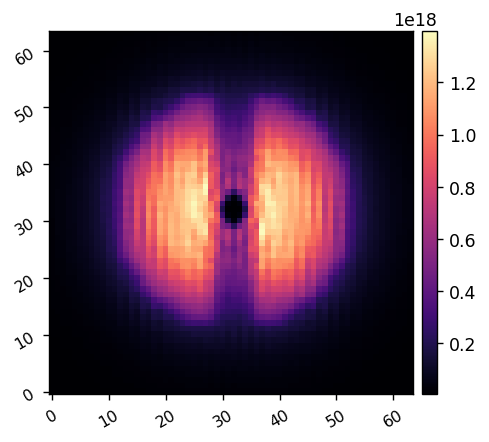

In [11]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf,npsf))

In [12]:
misc.save_fits('hcipy_iefc_1dm_response_matrix.fits', response_matrix)
misc.save_fits('hcipy_iefc_1dm_response_cube.fits', response_cube)

Saved data to:  hcipy_iefc_1dm_response_matrix.fits
Saved data to:  hcipy_iefc_1dm_response_cube.fits


In [26]:
response_cube.shape

(320, 2, 4096)

In [44]:
control_mask.sum()

472

In [43]:
differential_images[:, control_mask.ravel()].ravel().shape

(944,)

In [27]:
cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=1e-1)

Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=1e-1)

6.656605259046694e+34

1.515153252899394e+35

(944, 320)

(944, 320)

(320,)

(320, 320)

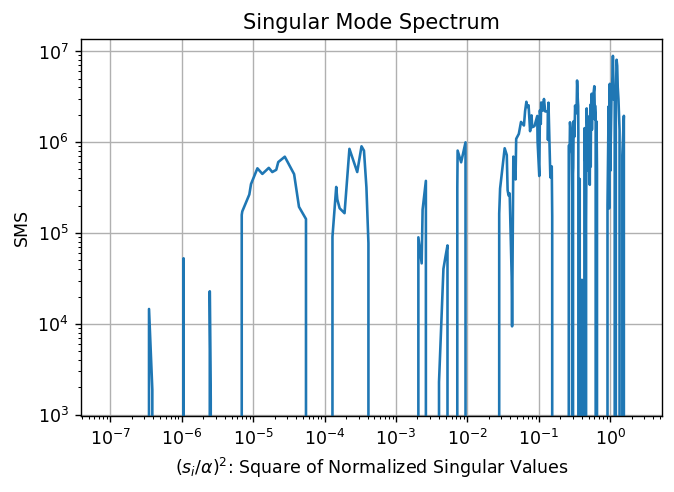

In [62]:
U, s, V = np.linalg.svd(response_matrix, full_matrices=False)
alpha2 = np.max( np.diag( np.real( response_matrix.conj().T @ response_matrix ) ) )
display(alpha2, s.max()**2)

display(response_matrix.shape, U.shape, s.shape, V.shape)
measurement_vector = differential_images[:, control_mask.ravel()].ravel()
SMS = U.T.dot(measurement_vector)

Nbox = 11
box = np.ones(Nbox)/Nbox
SMS = np.convolve(SMS, box, mode='same')

x = (s**2/alpha2)
y = SMS

import matplotlib.pyplot as plt

fig = plt.figure(dpi=125, figsize=(6,4))
plt.loglog(wfsc.utils.ensure_np_array(x), wfsc.utils.ensure_np_array(y))
plt.title('Singular Mode Spectrum')
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
plt.xlabel(r'$(s_{i}/\alpha)^2$: Square of Normalized Singular Values')
plt.ylabel('SMS')
plt.grid()
plt.close()
display(fig)


Running I-EFC...
	Closed-loop iteration 0 / 10


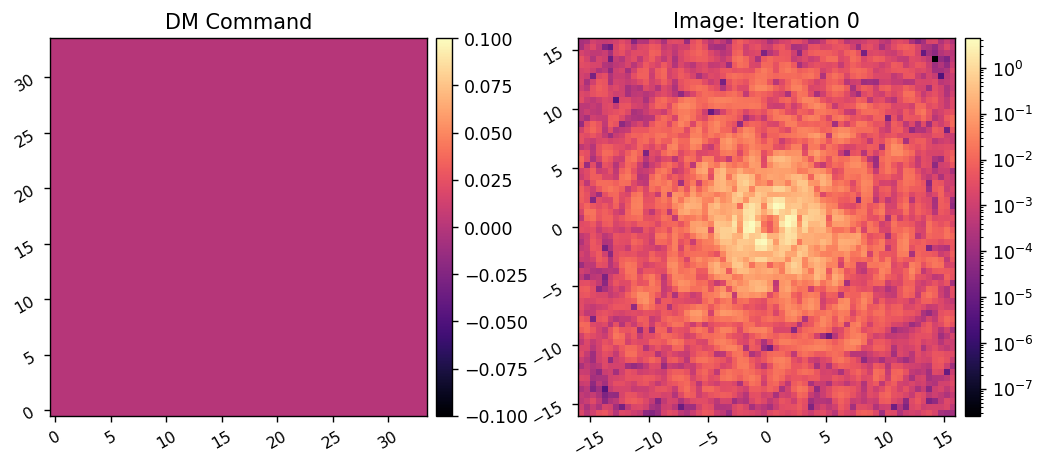

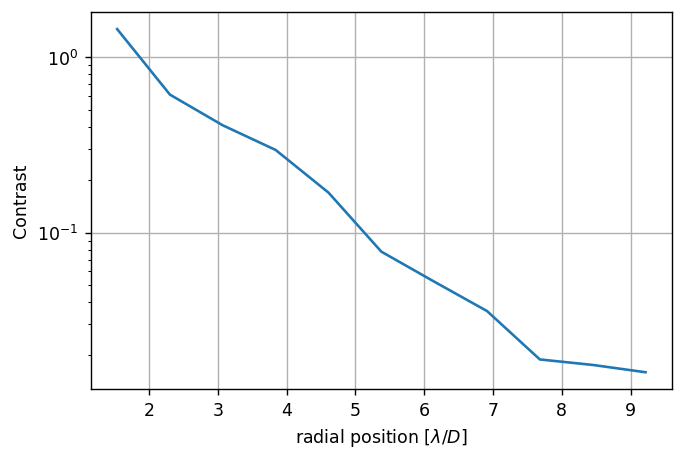

	Closed-loop iteration 1 / 10


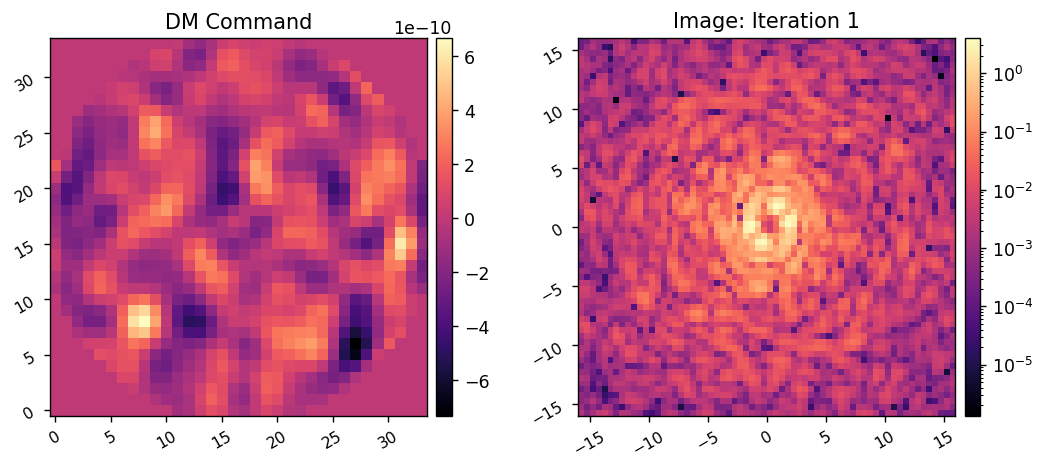

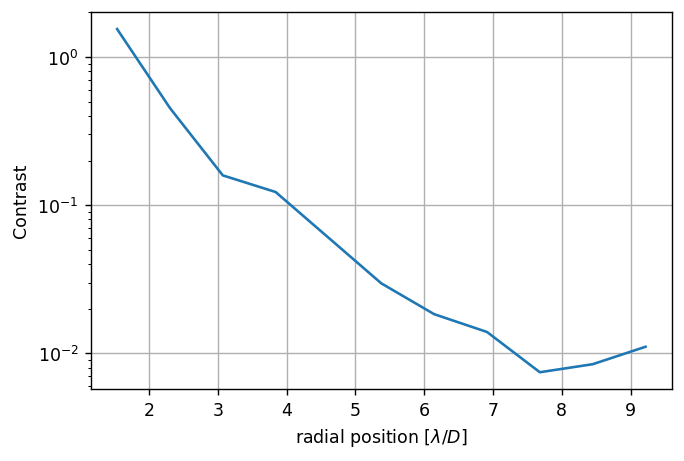

	Closed-loop iteration 2 / 10


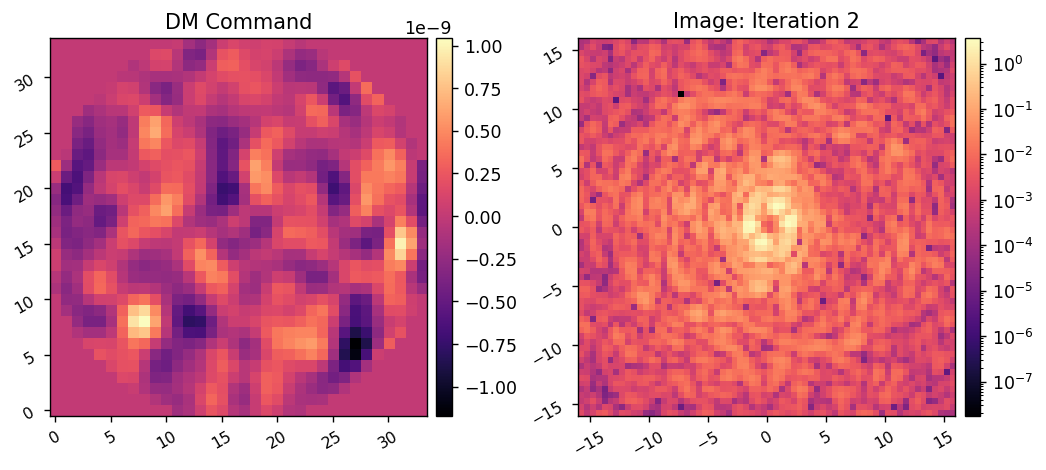

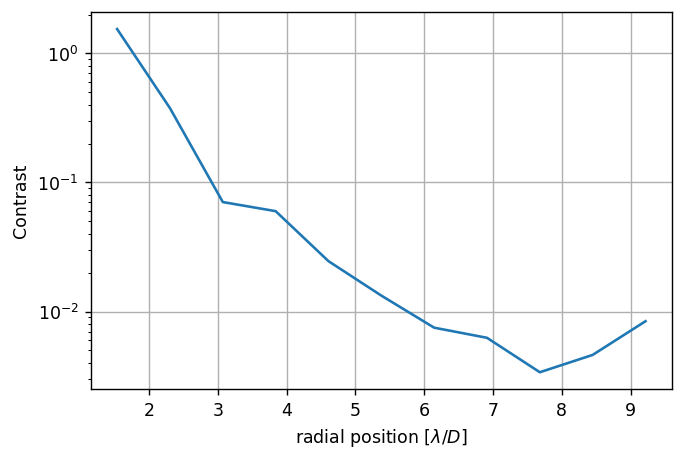

	Closed-loop iteration 3 / 10


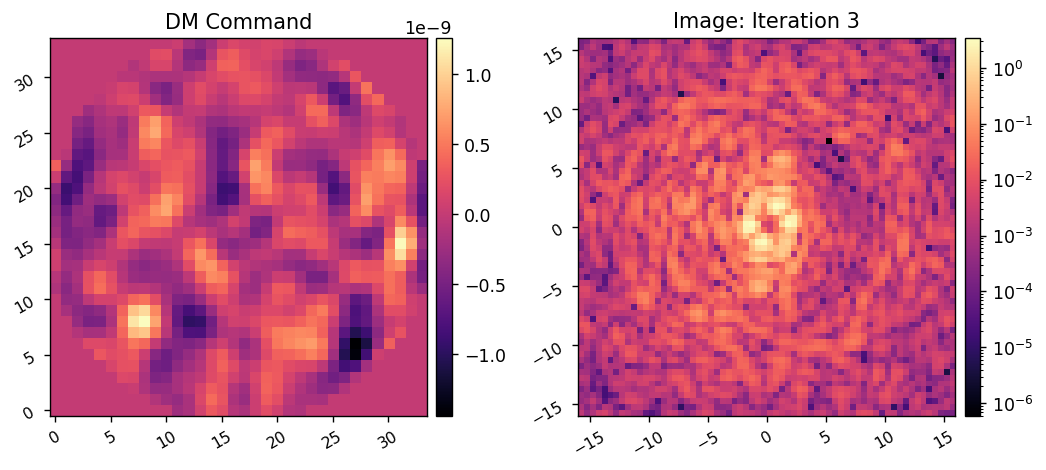

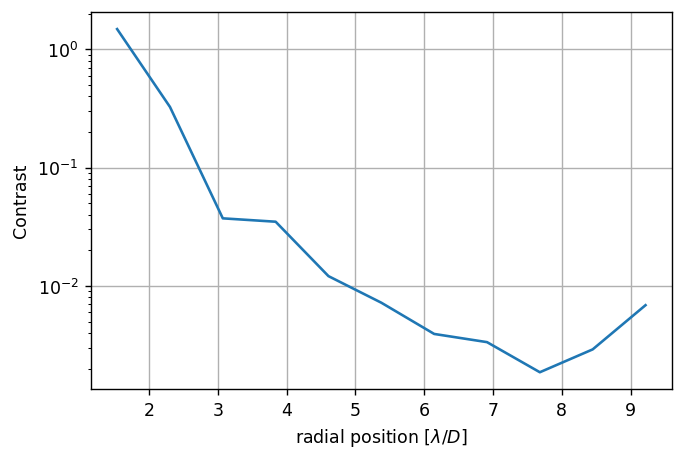

	Closed-loop iteration 4 / 10


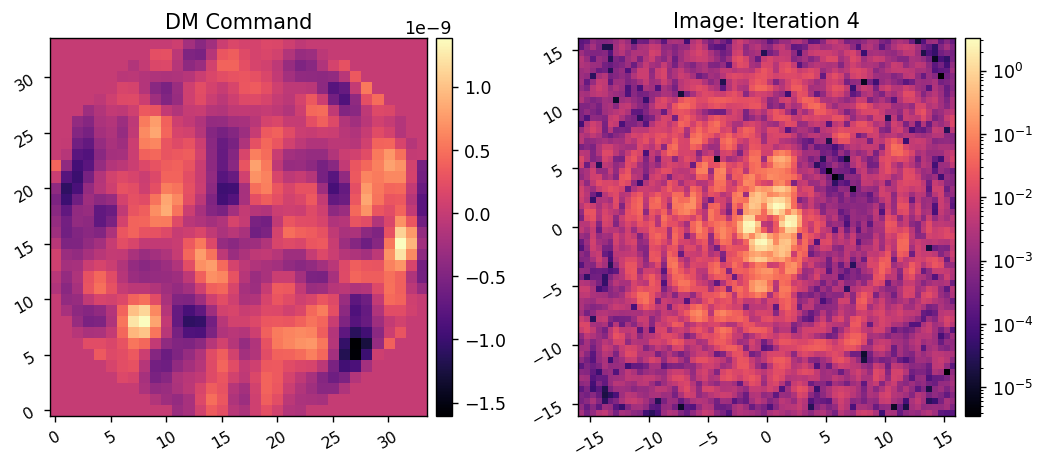

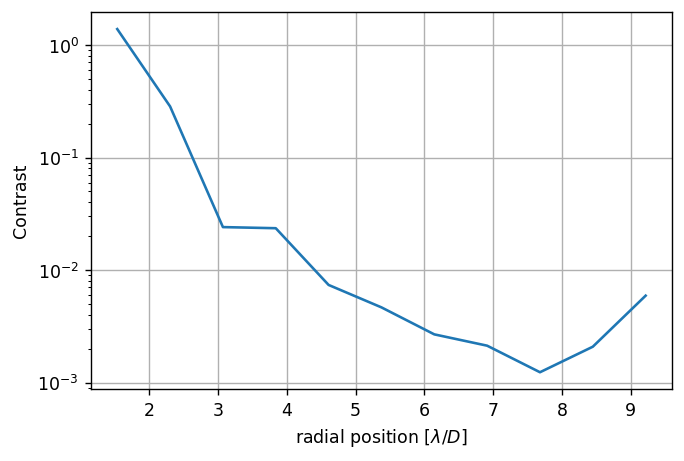

	Closed-loop iteration 5 / 10


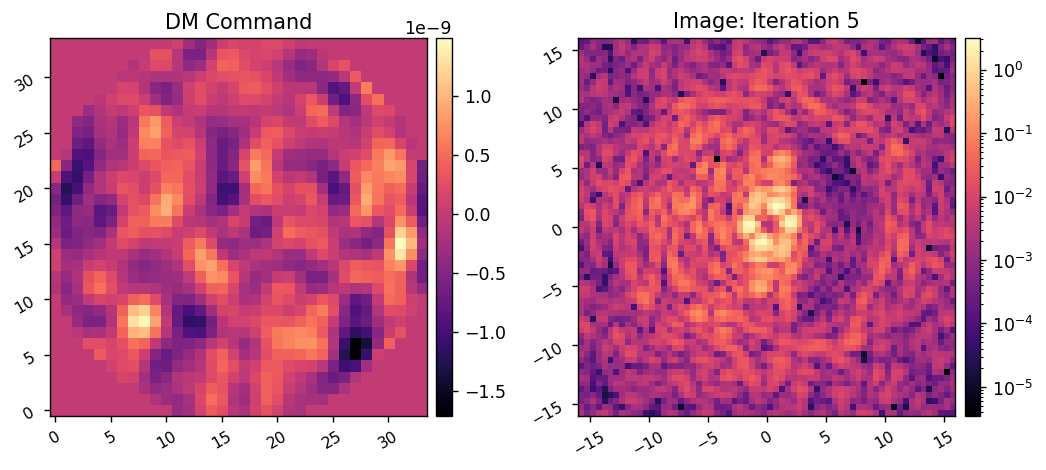

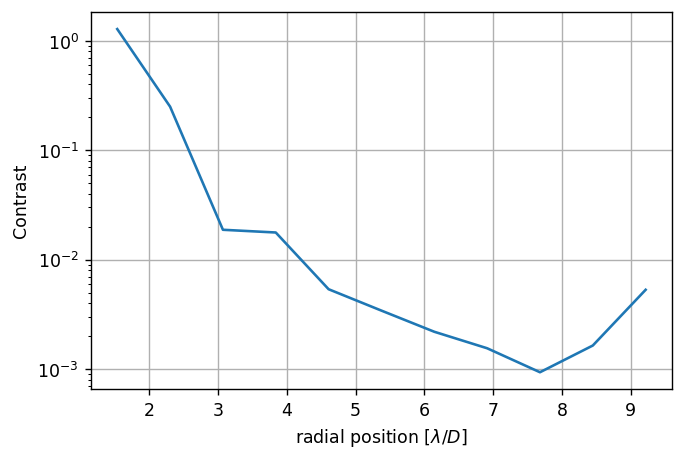

	Closed-loop iteration 6 / 10


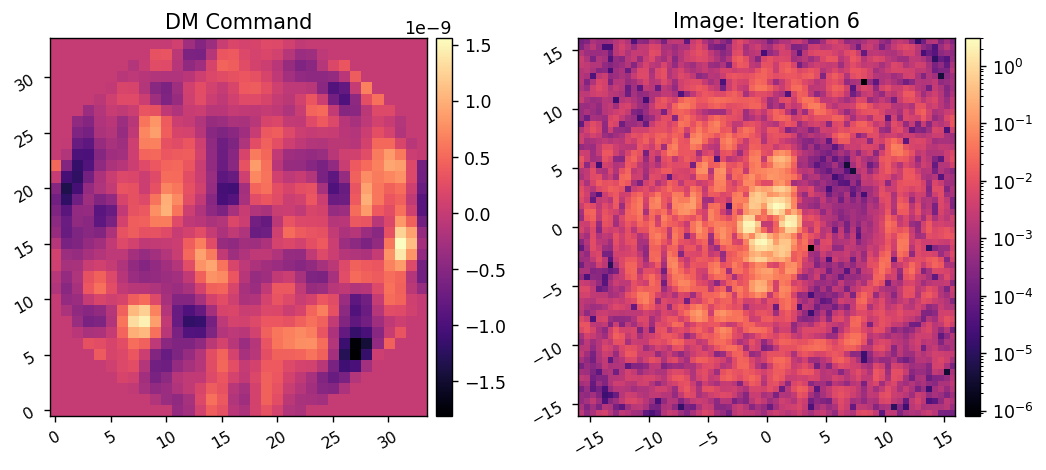

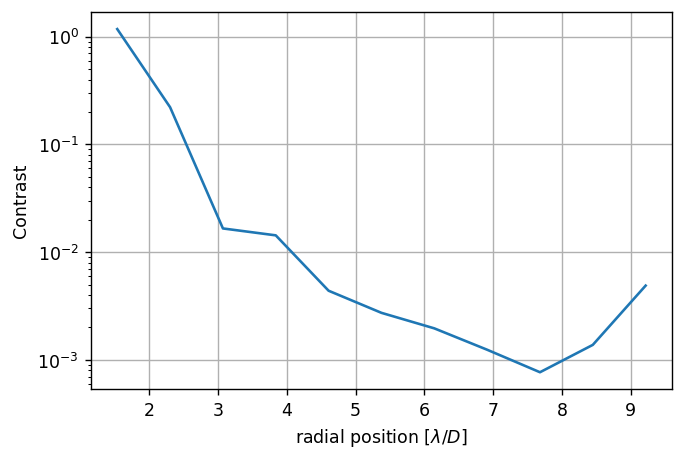

	Closed-loop iteration 7 / 10


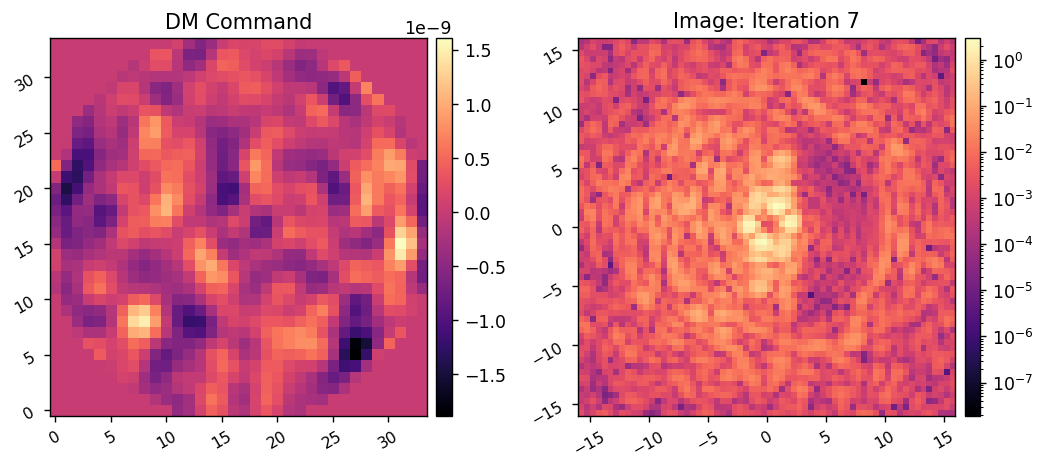

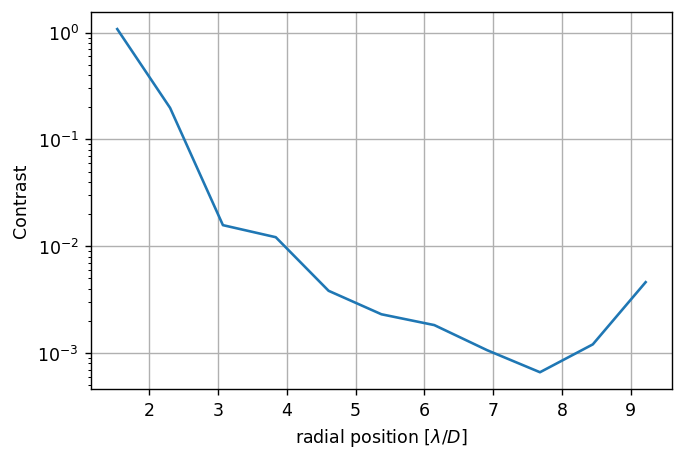

	Closed-loop iteration 8 / 10


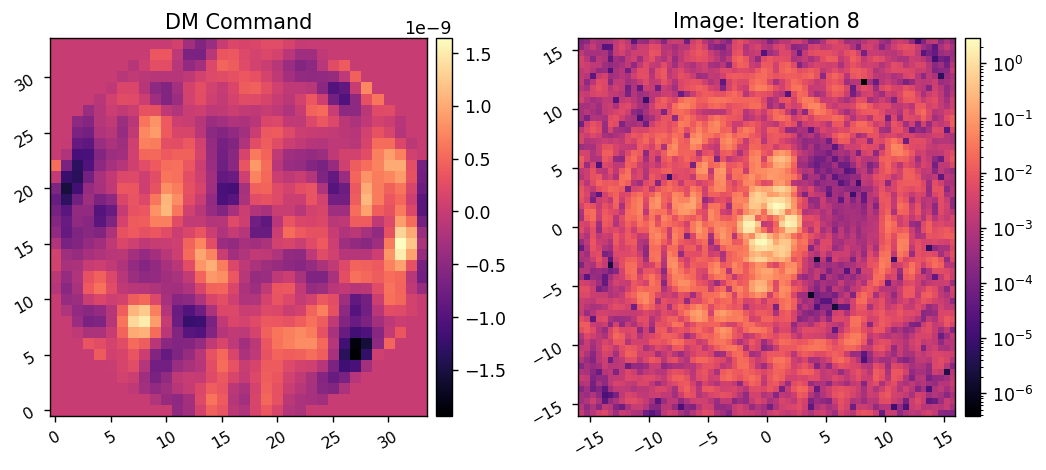

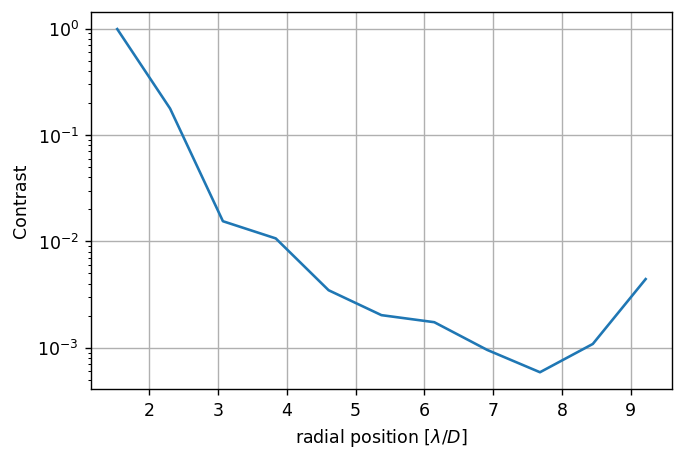

	Closed-loop iteration 9 / 10


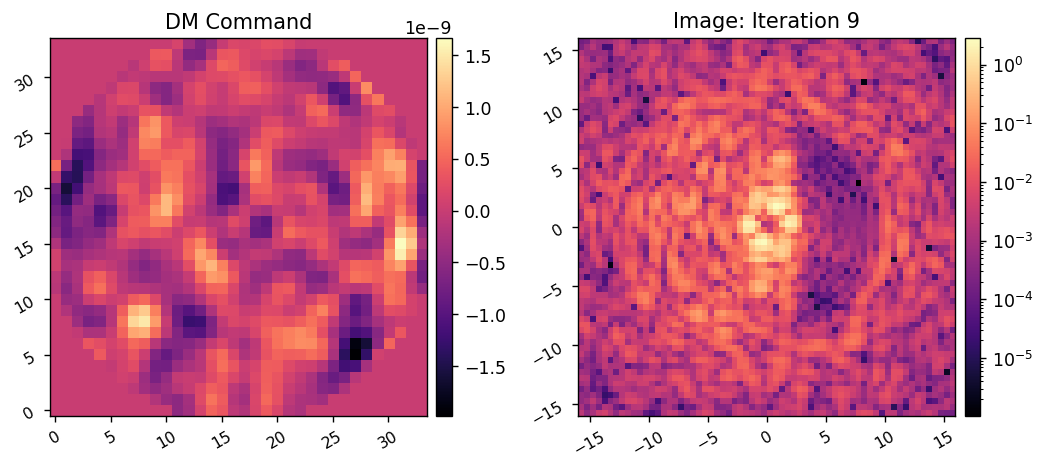

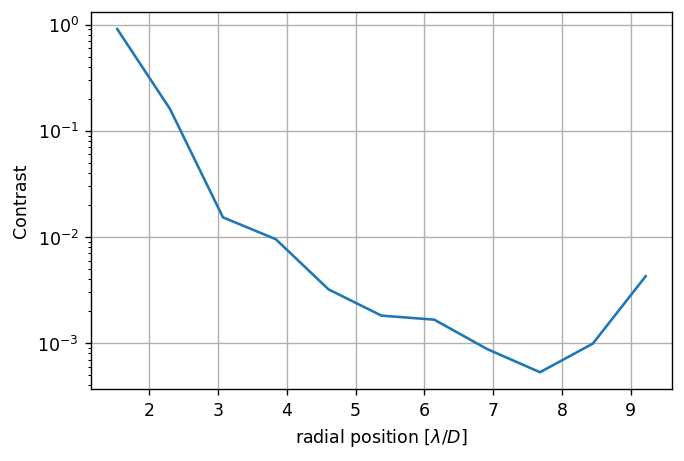

	Closed-loop iteration 10 / 10


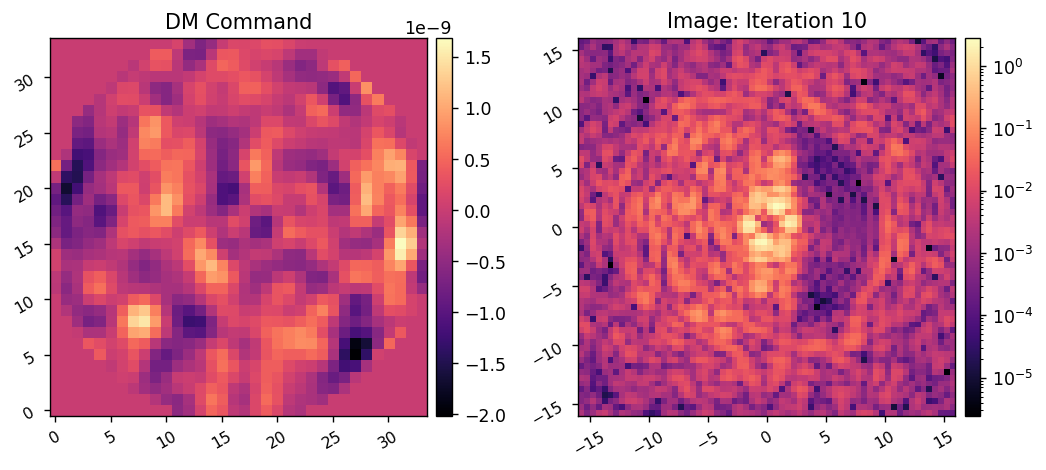

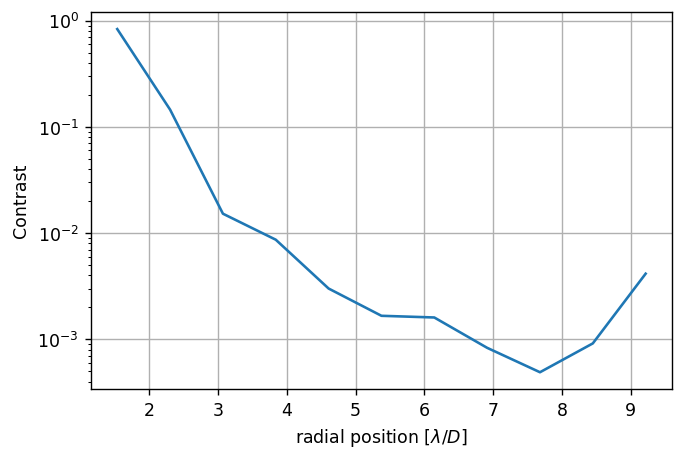

I-EFC loop completed in 18.594s.
Running I-EFC...
	Closed-loop iteration 0 / 20


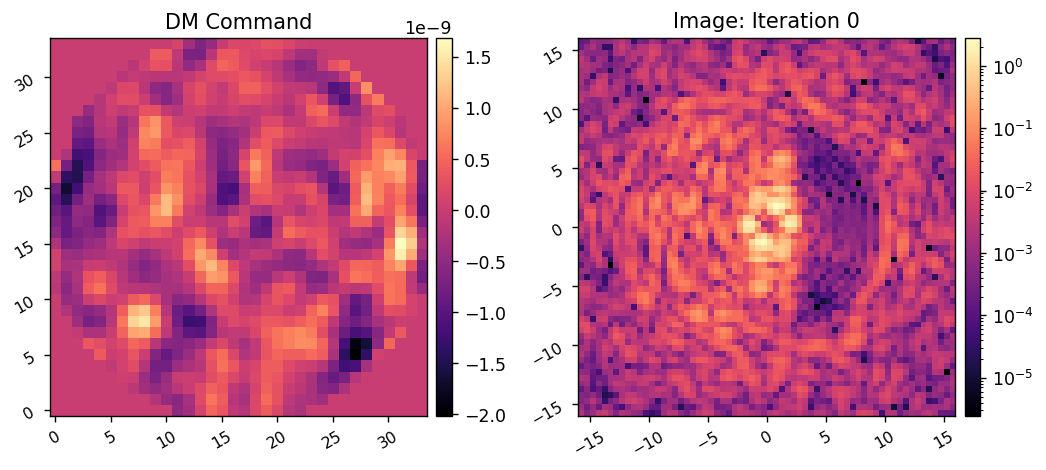

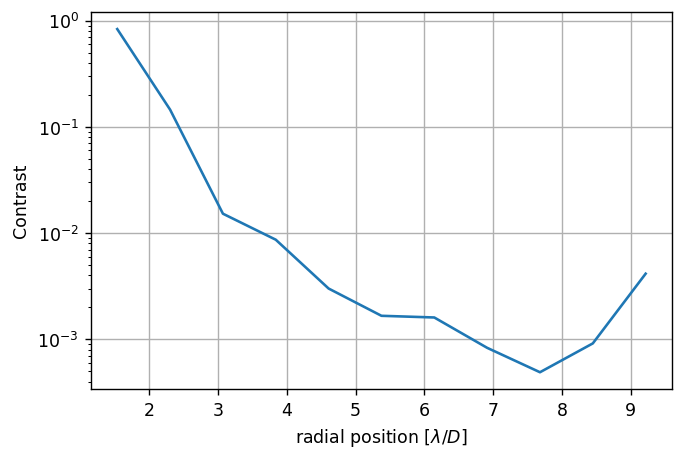

	Closed-loop iteration 1 / 20


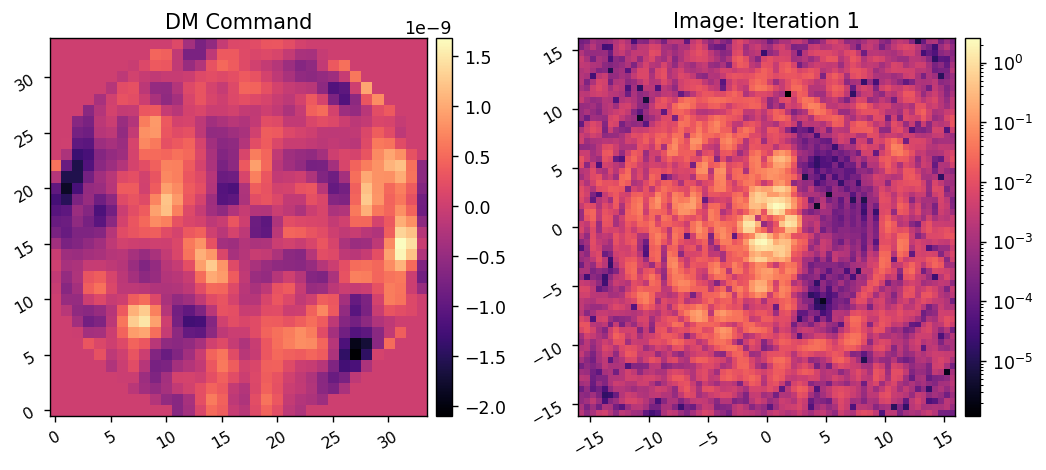

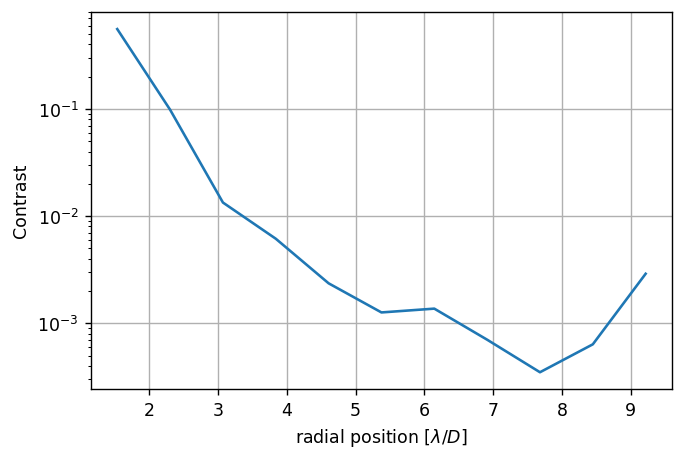

	Closed-loop iteration 2 / 20


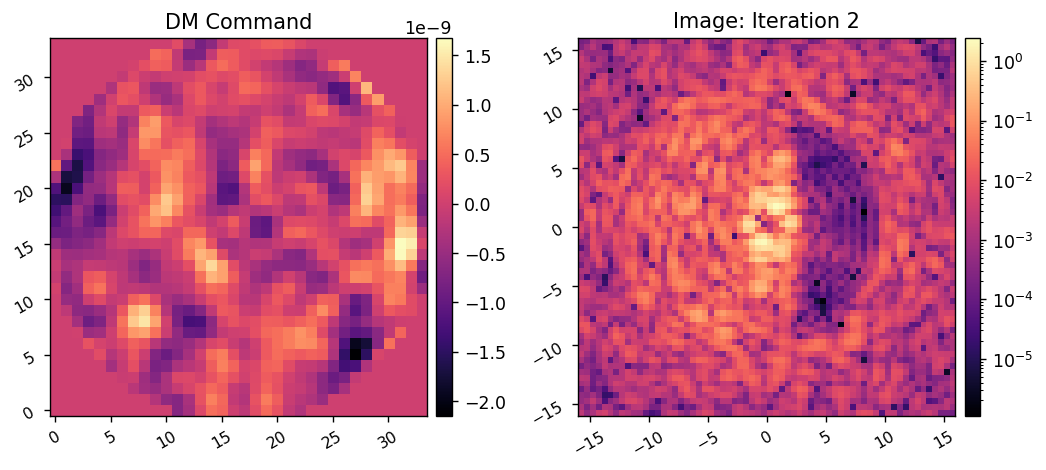

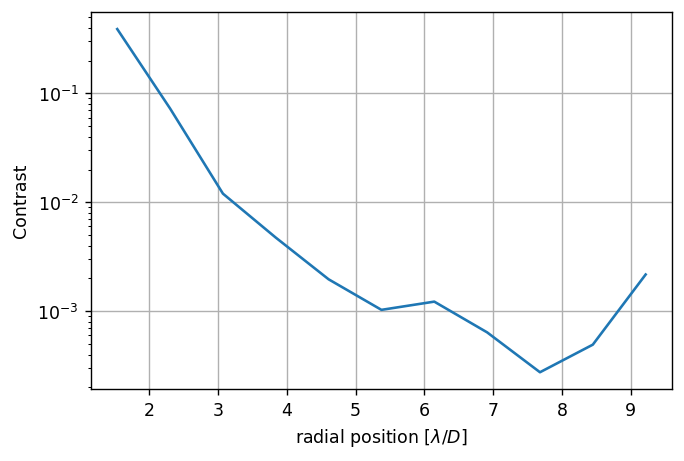

	Closed-loop iteration 3 / 20


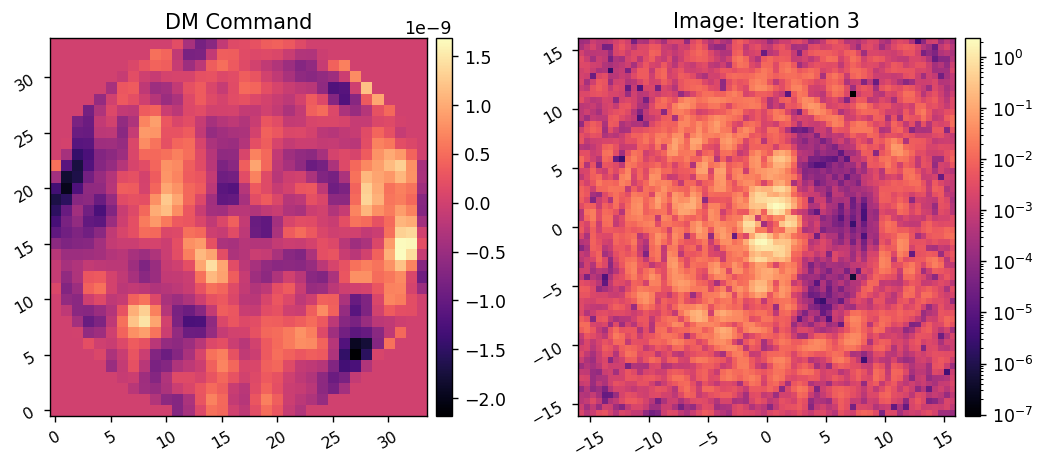

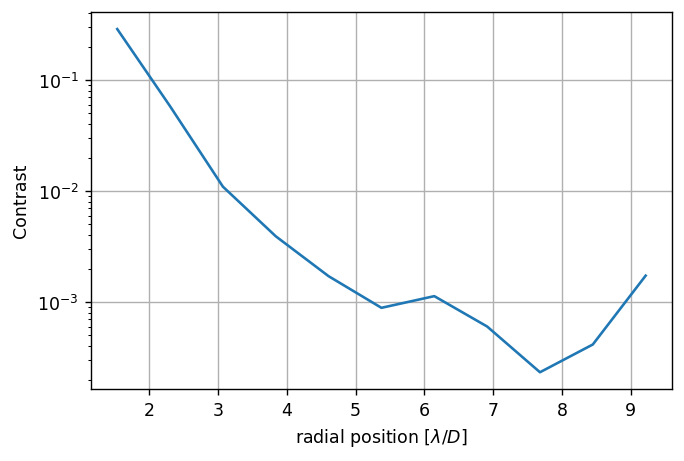

	Closed-loop iteration 4 / 20


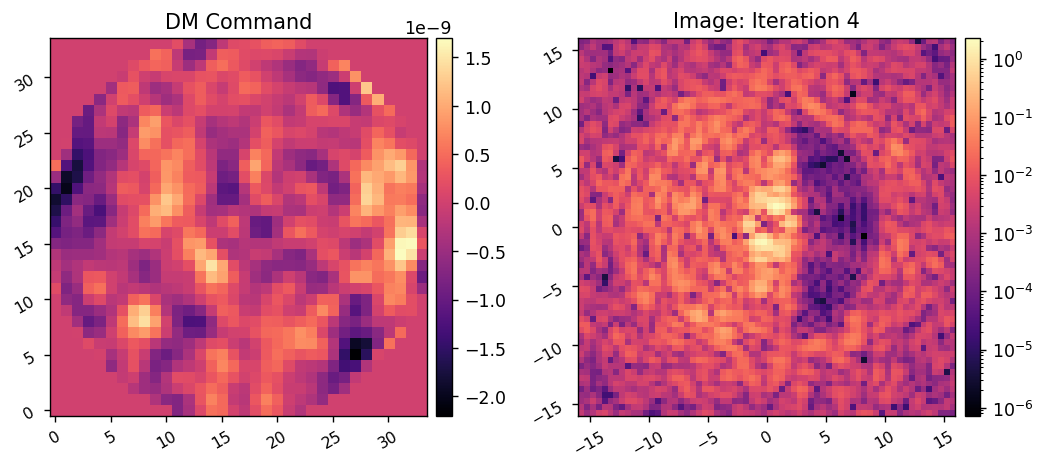

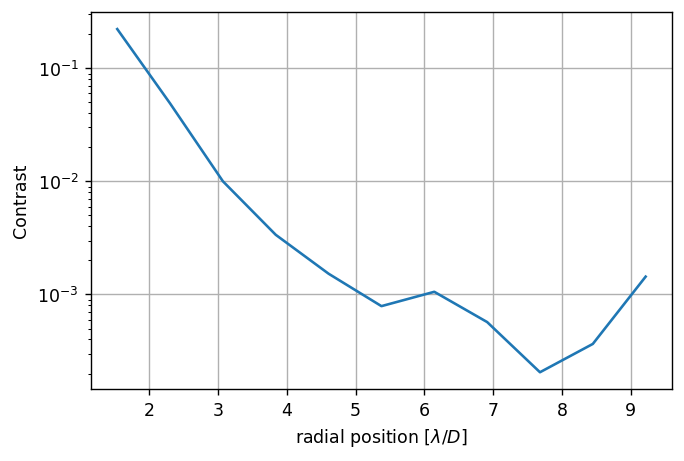

	Closed-loop iteration 5 / 20


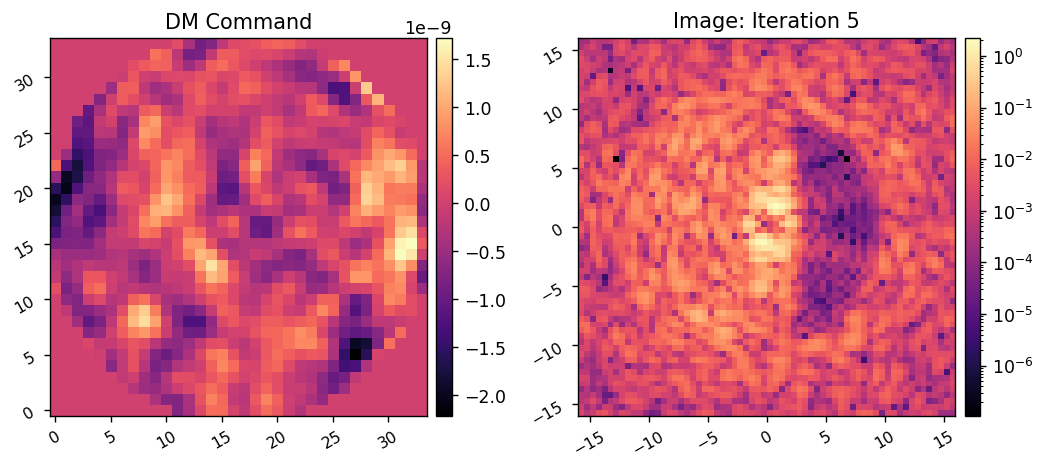

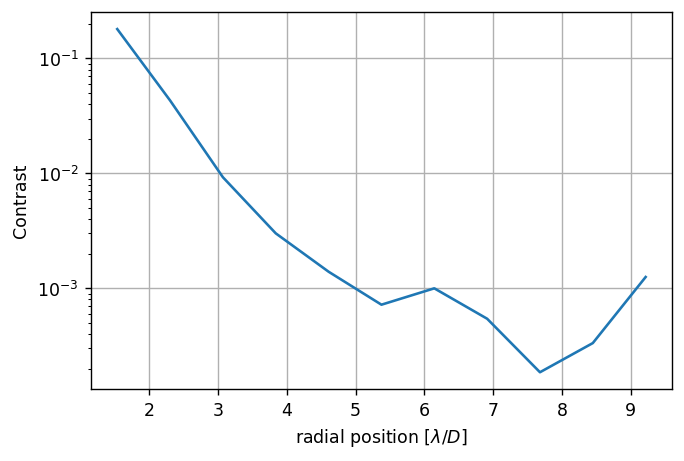

	Closed-loop iteration 6 / 20


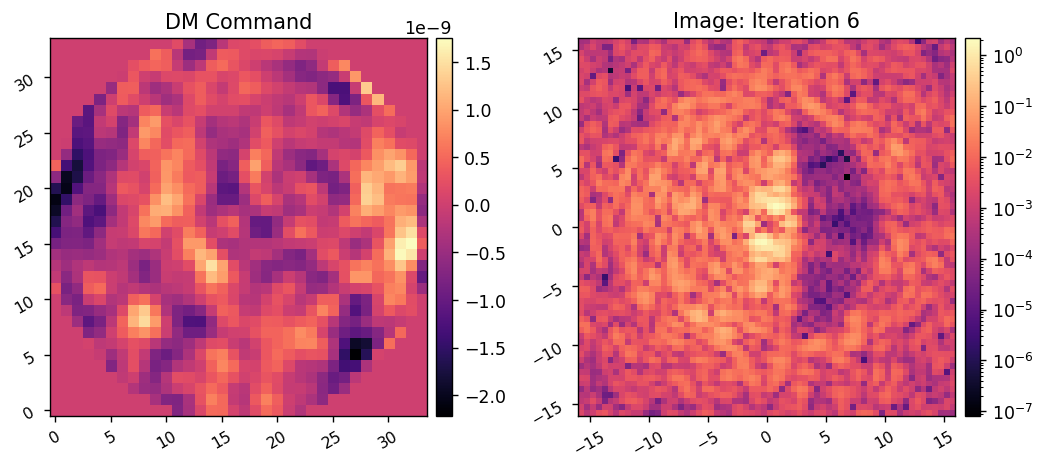

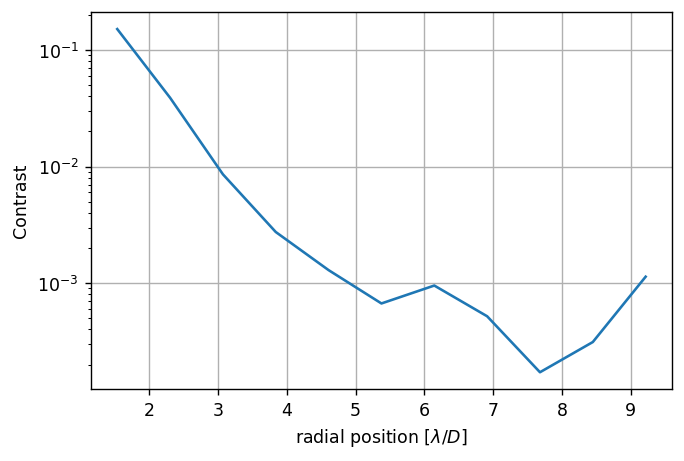

	Closed-loop iteration 7 / 20


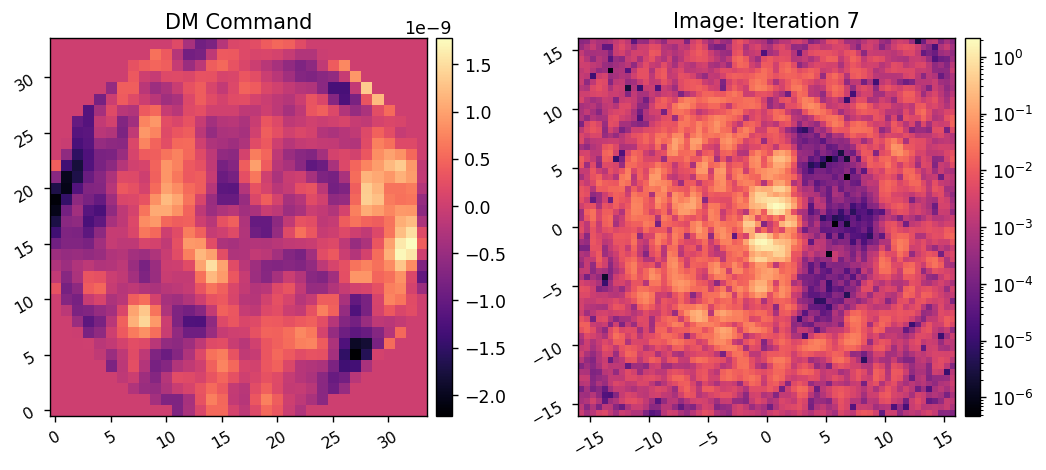

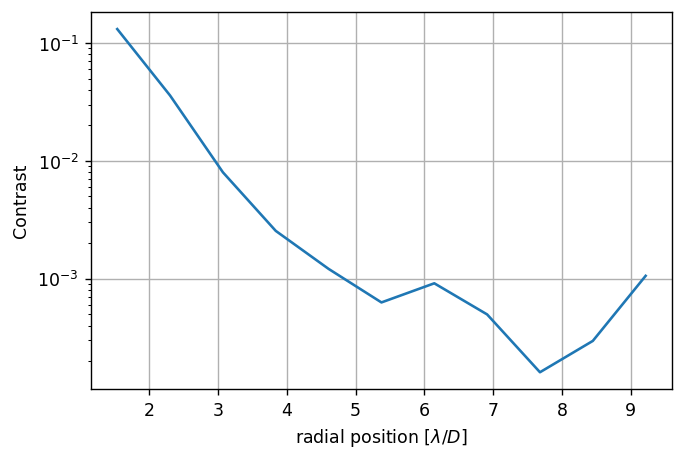

	Closed-loop iteration 8 / 20


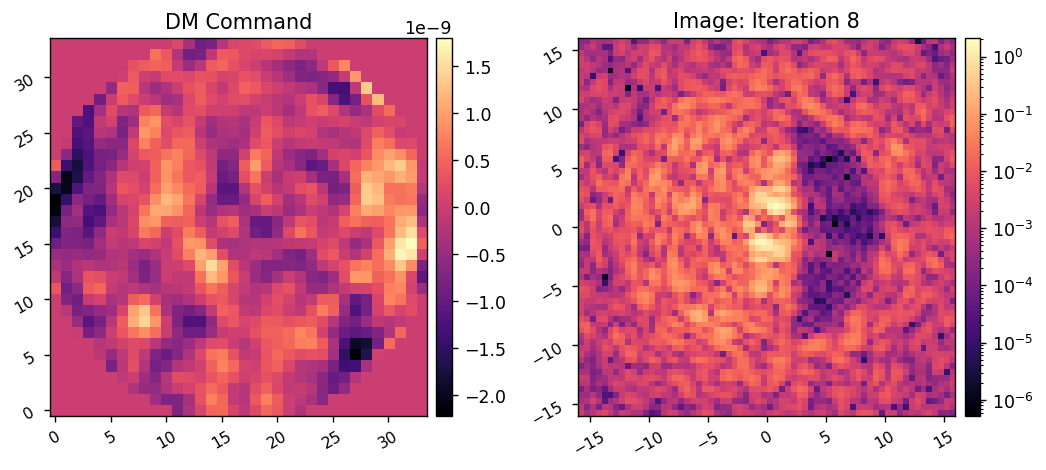

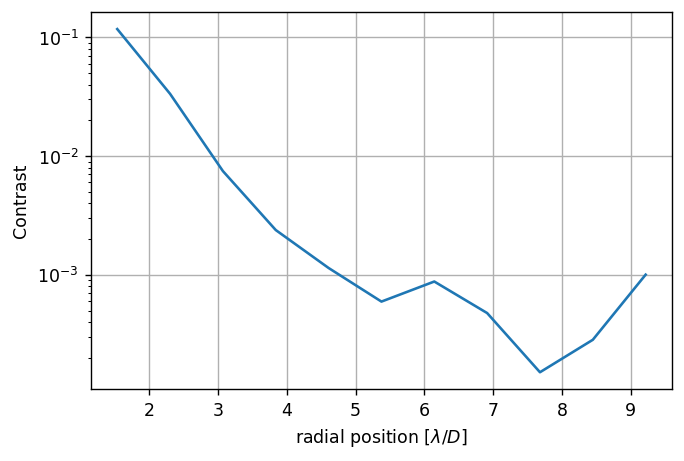

	Closed-loop iteration 9 / 20


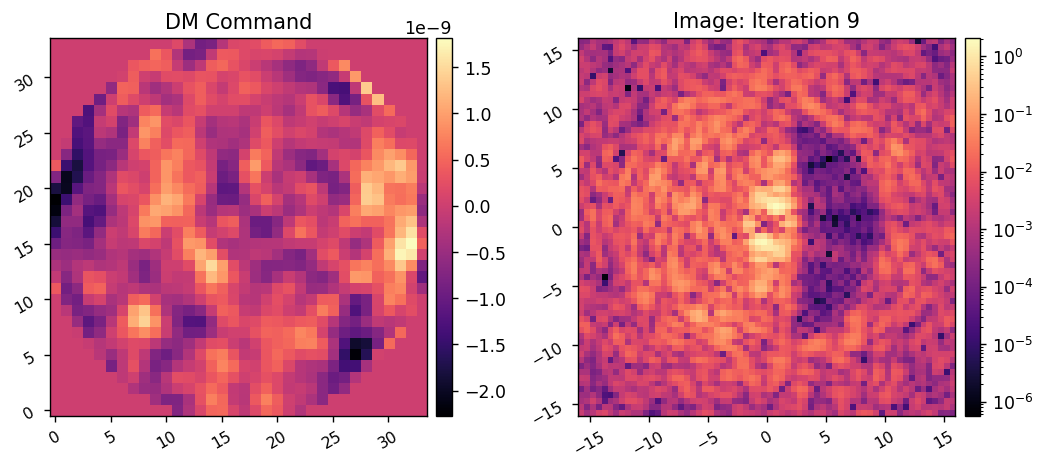

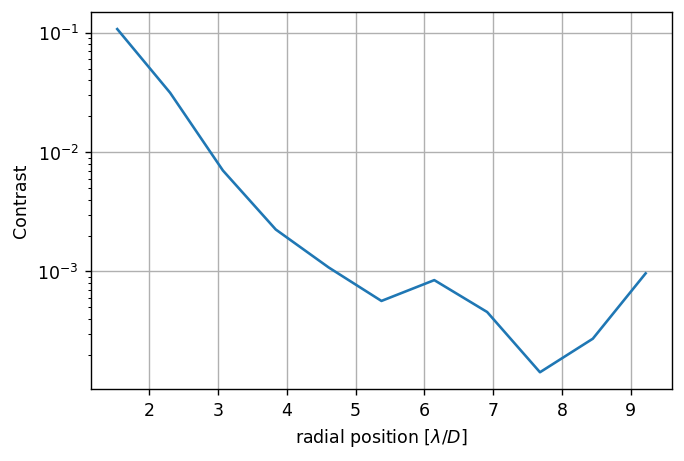

	Closed-loop iteration 10 / 20


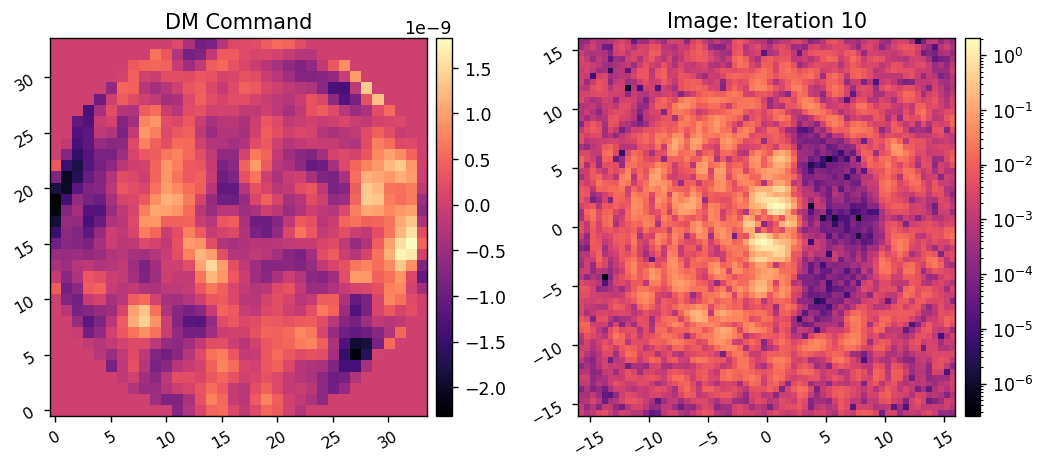

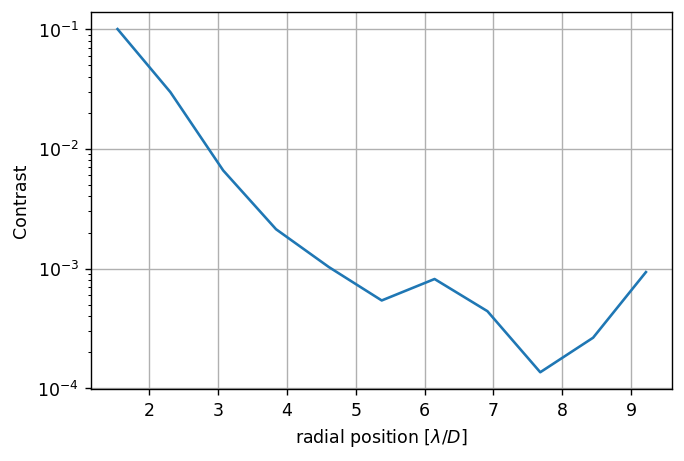

	Closed-loop iteration 11 / 20


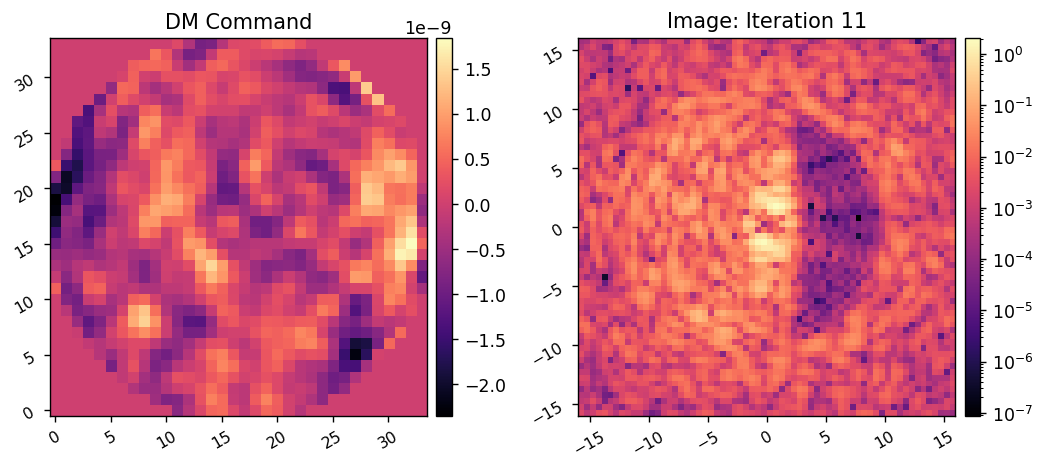

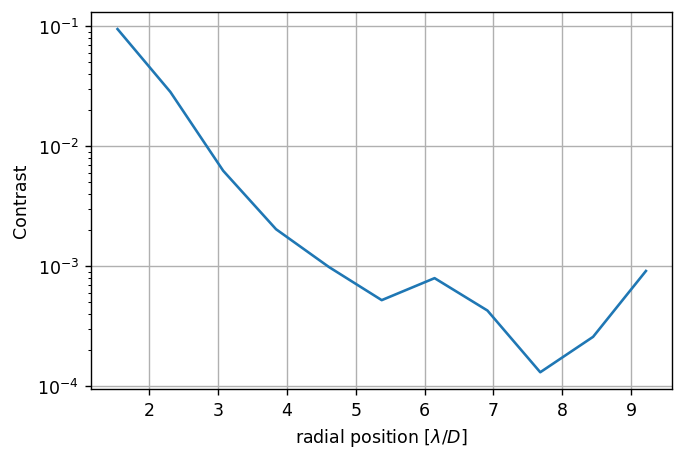

	Closed-loop iteration 12 / 20


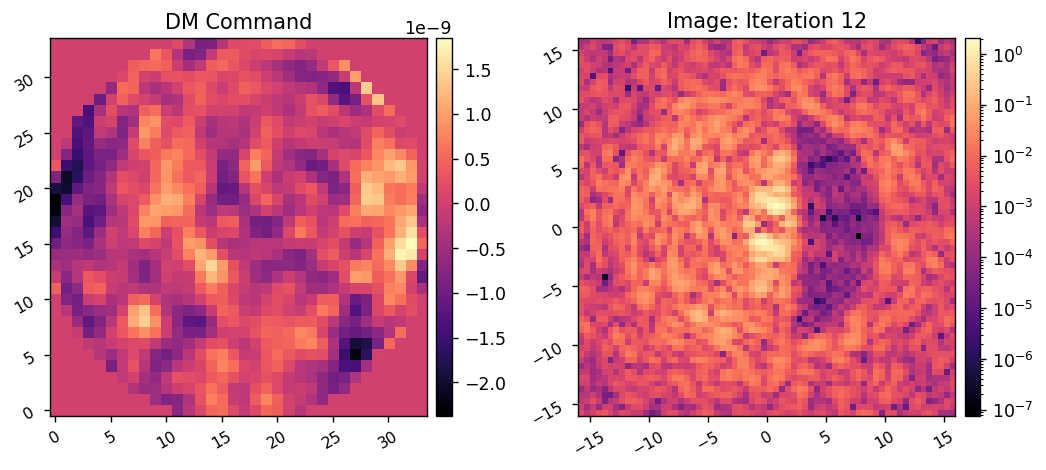

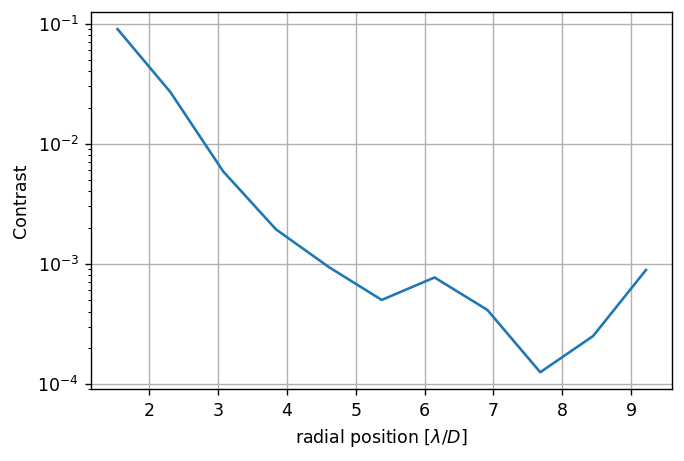

	Closed-loop iteration 13 / 20


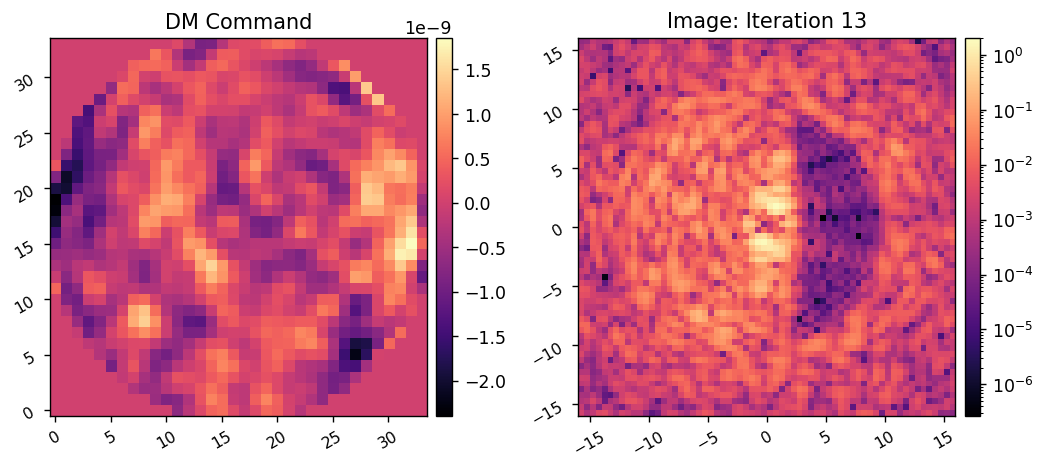

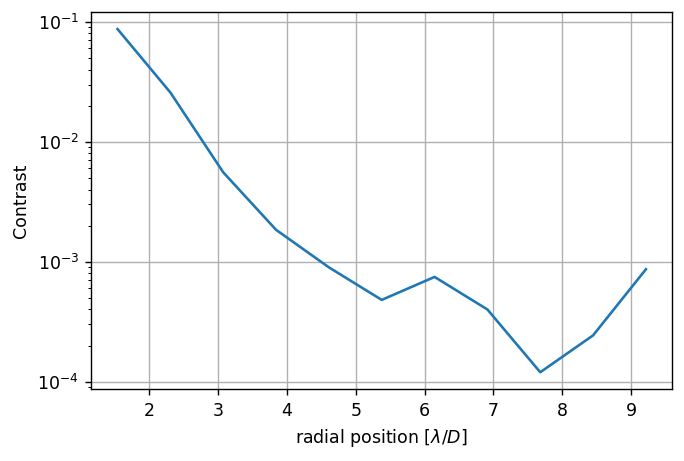

	Closed-loop iteration 14 / 20


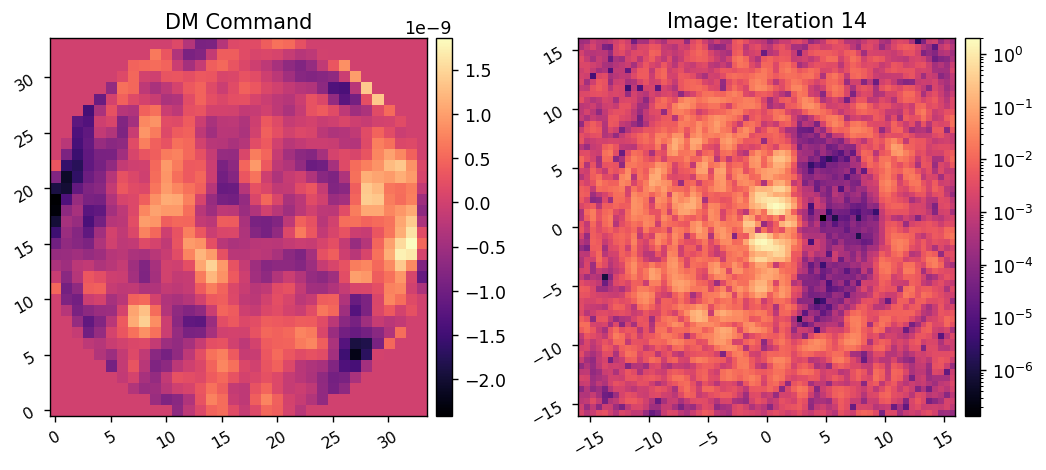

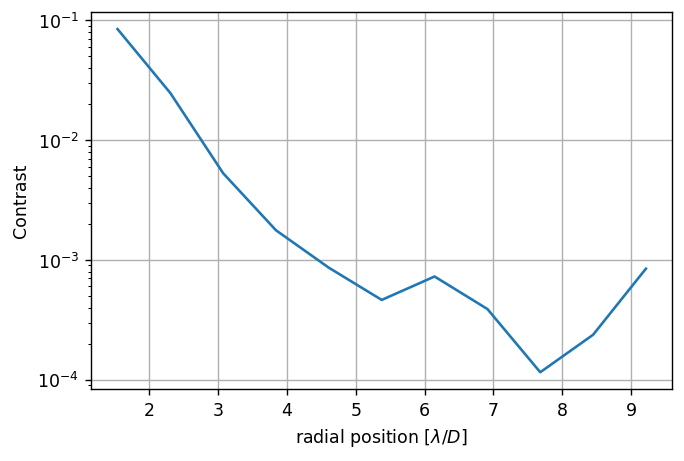

	Closed-loop iteration 15 / 20


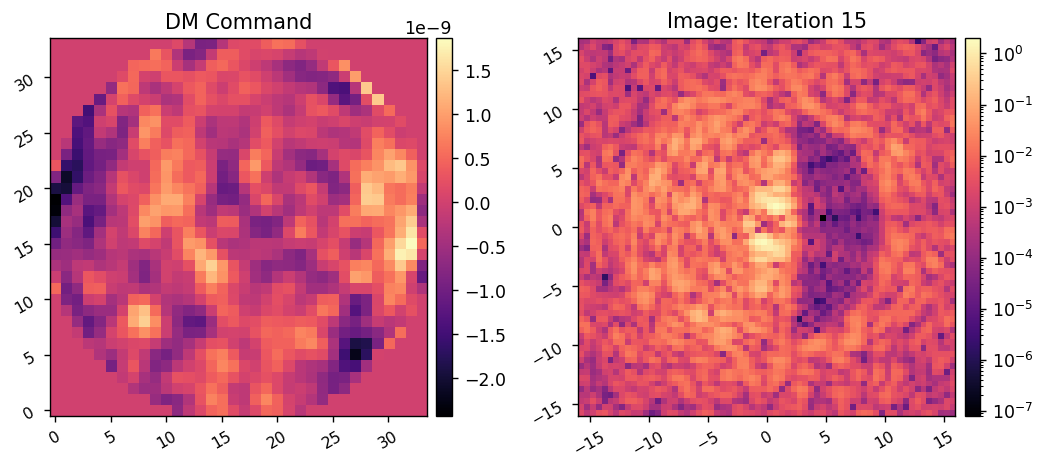

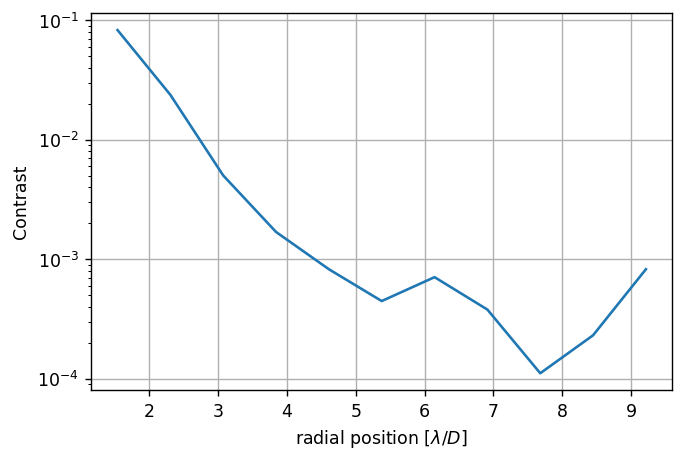

	Closed-loop iteration 16 / 20


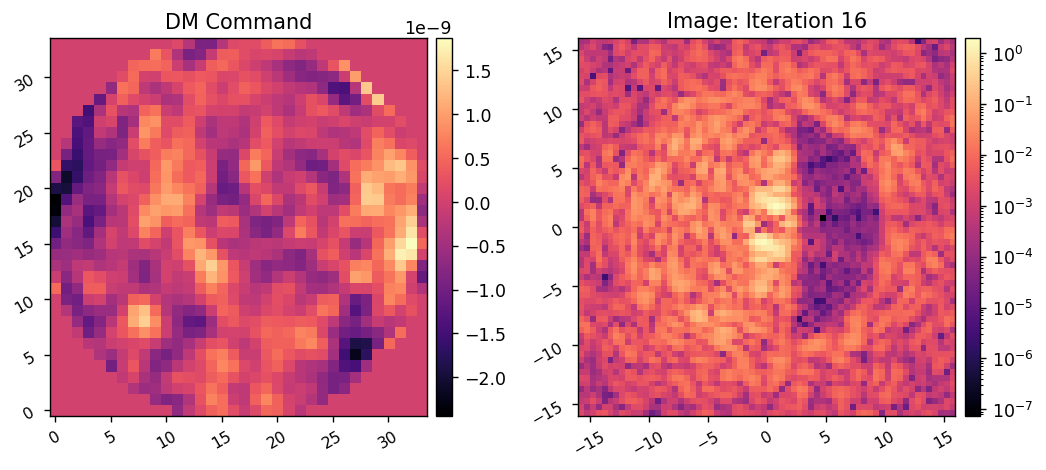

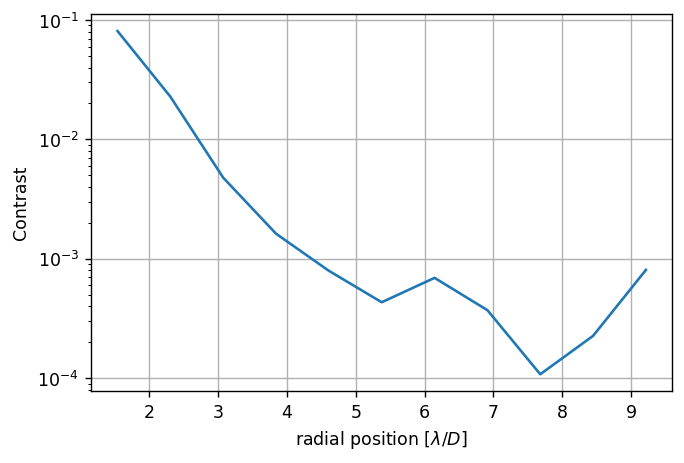

	Closed-loop iteration 17 / 20


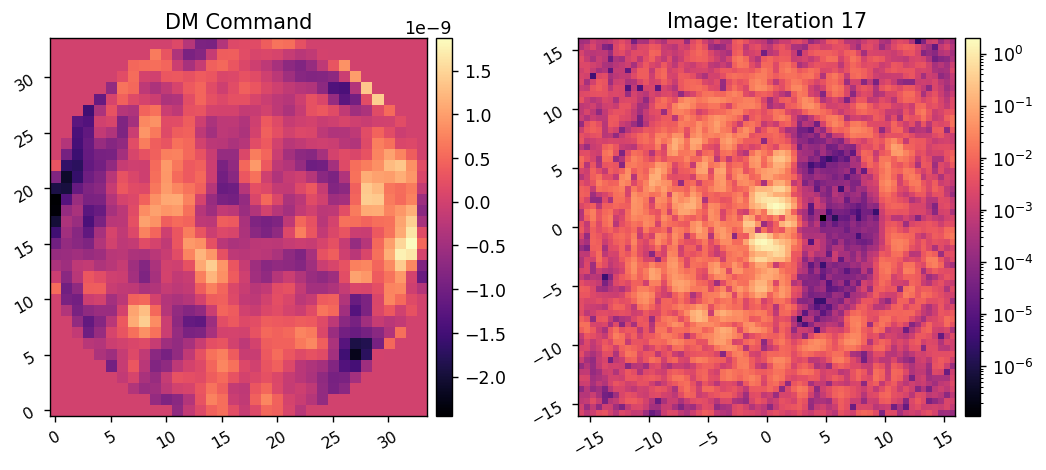

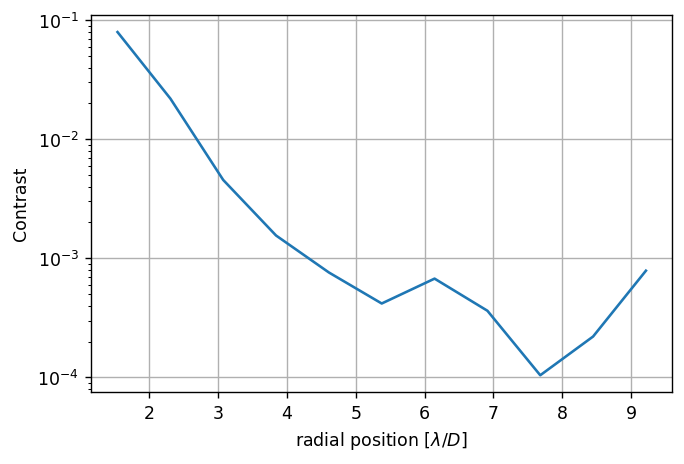

	Closed-loop iteration 18 / 20


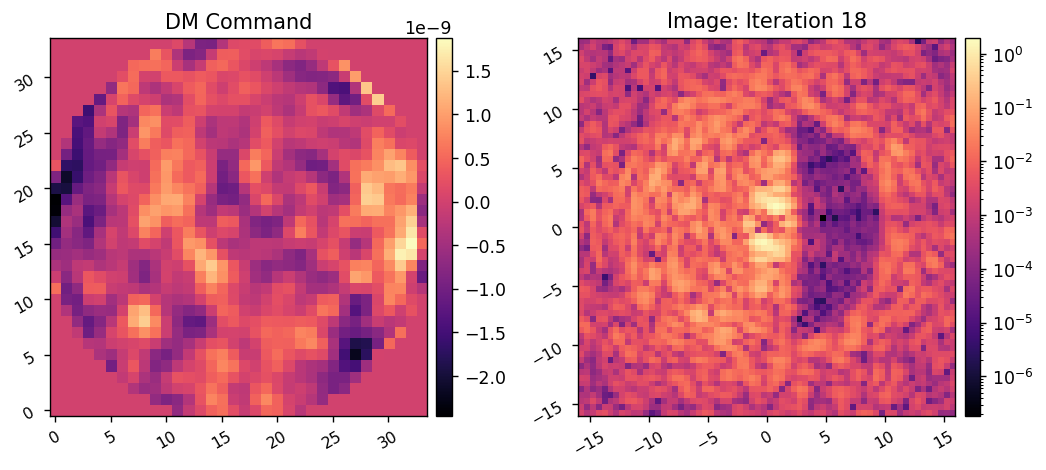

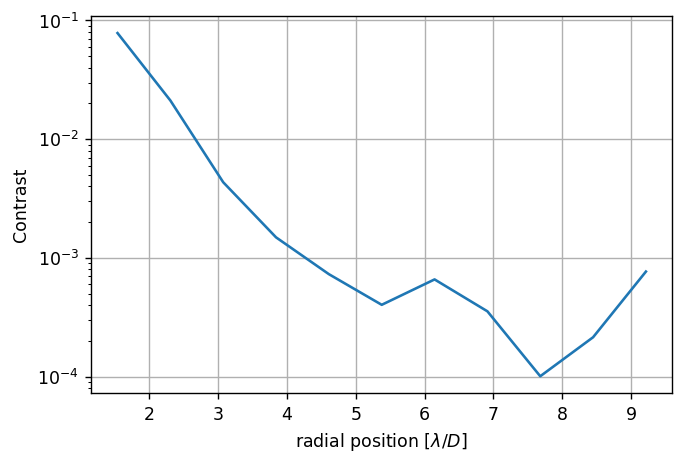

	Closed-loop iteration 19 / 20


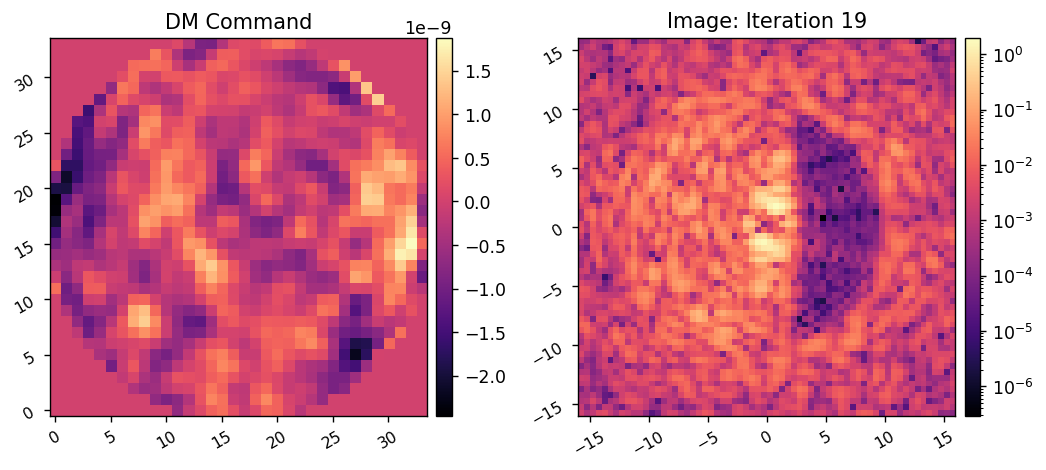

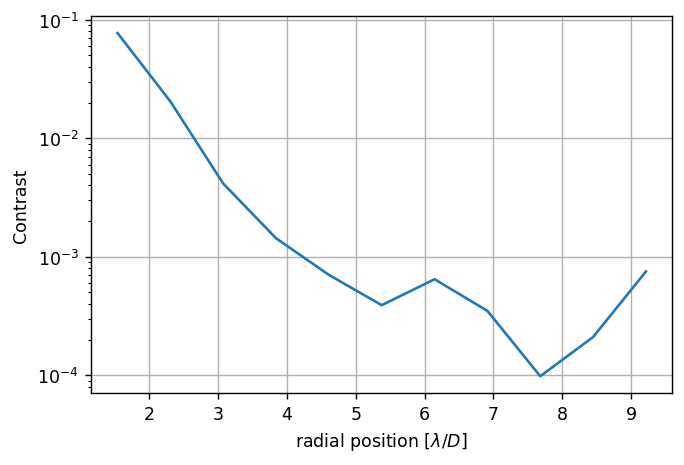

	Closed-loop iteration 20 / 20


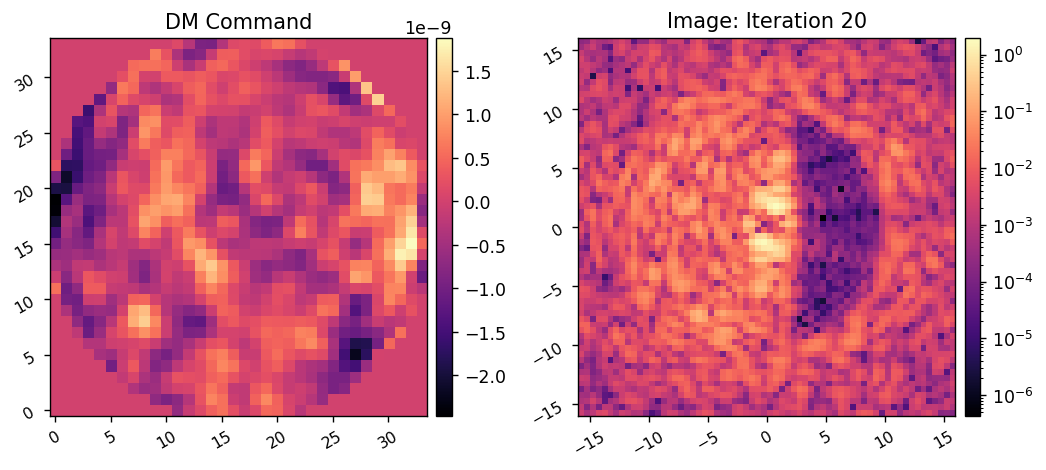

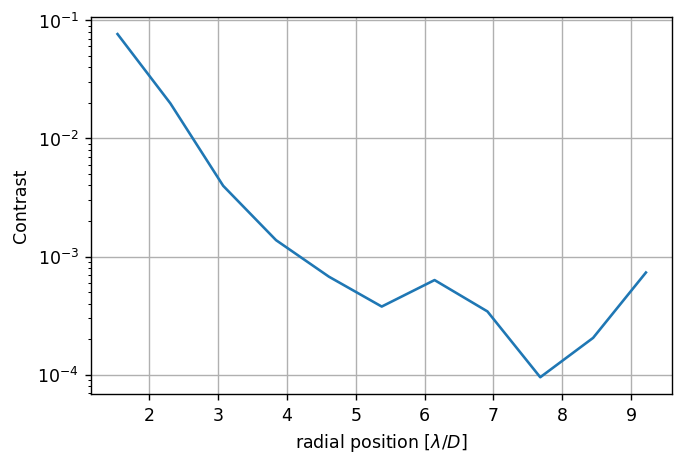

I-EFC loop completed in 35.820s.
Running I-EFC...
	Closed-loop iteration 0 / 20


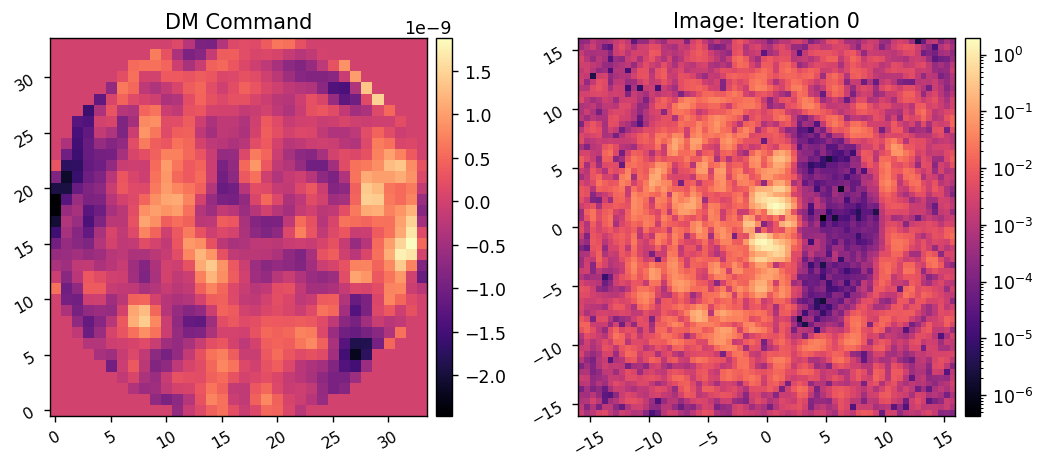

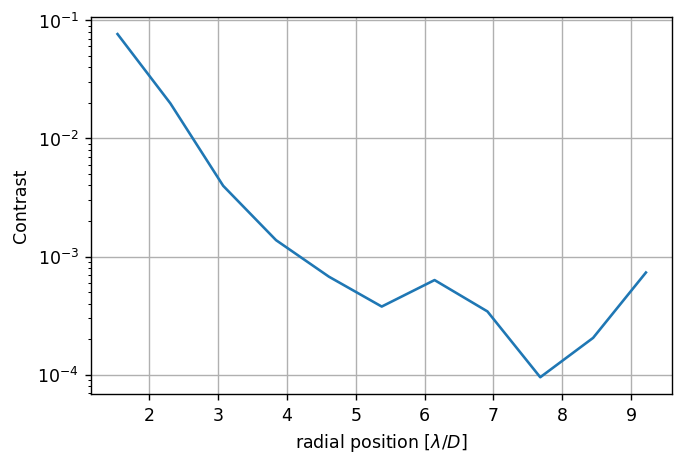

	Closed-loop iteration 1 / 20


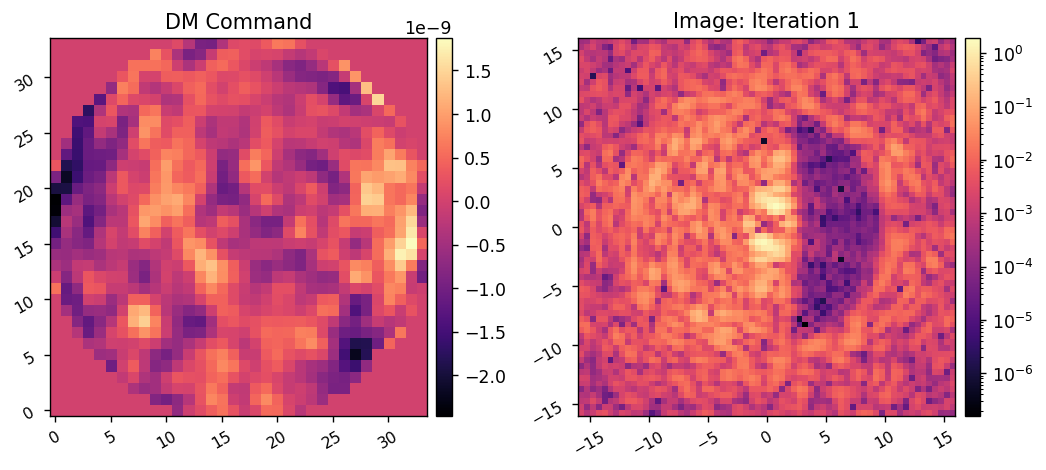

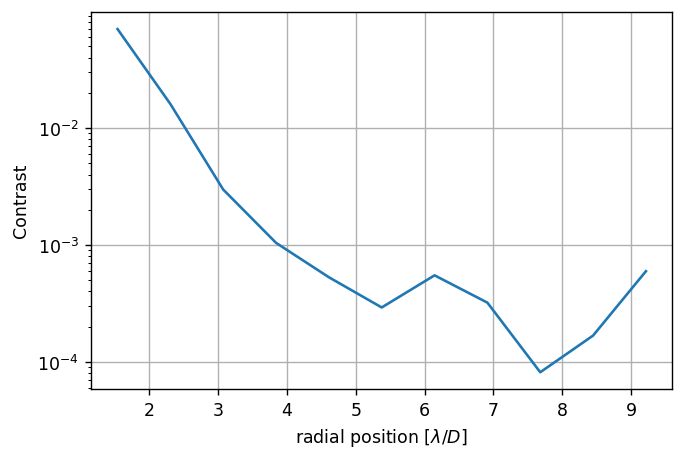

	Closed-loop iteration 2 / 20


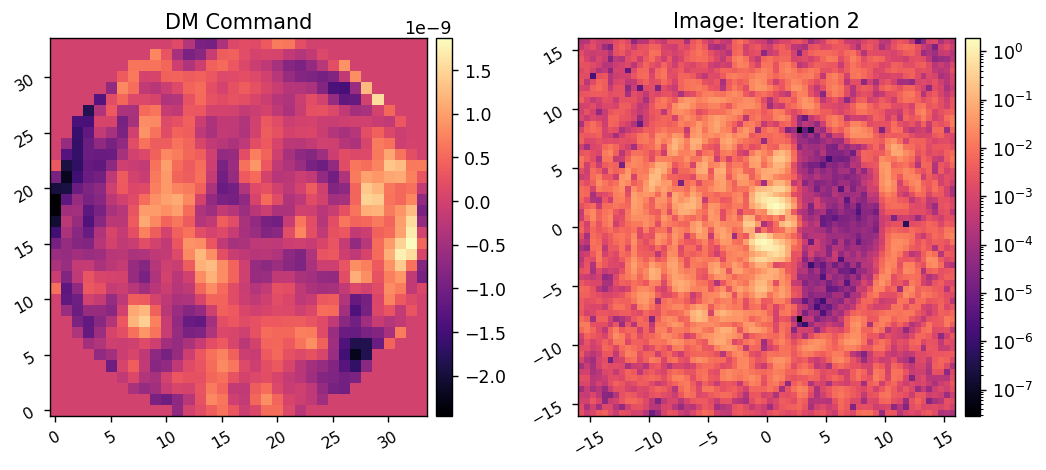

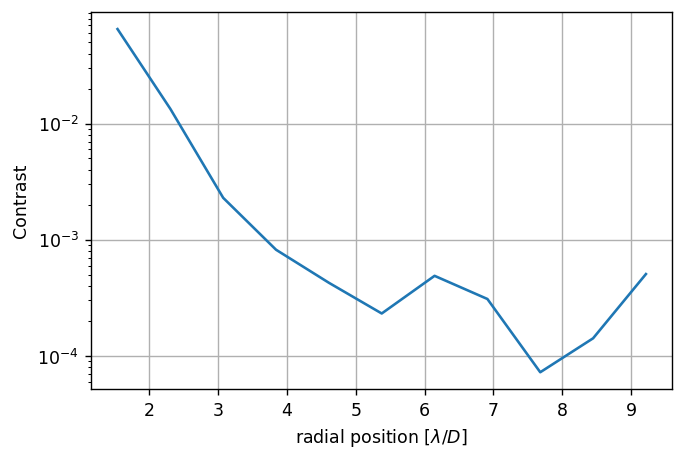

	Closed-loop iteration 3 / 20


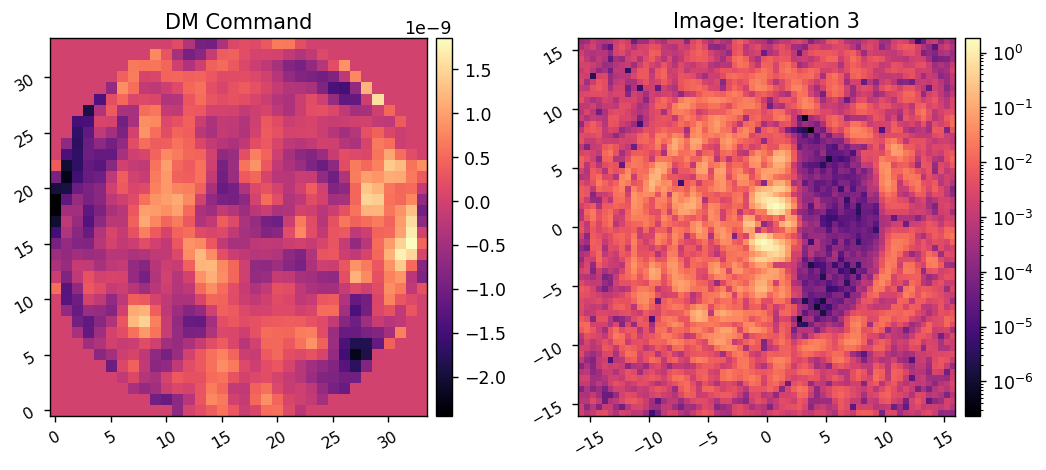

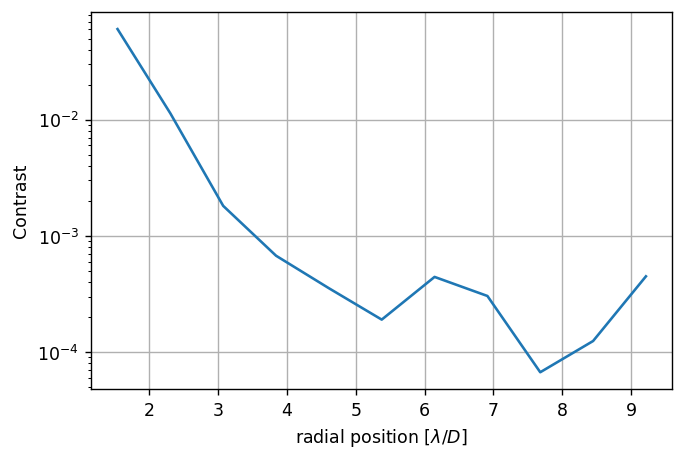

	Closed-loop iteration 4 / 20


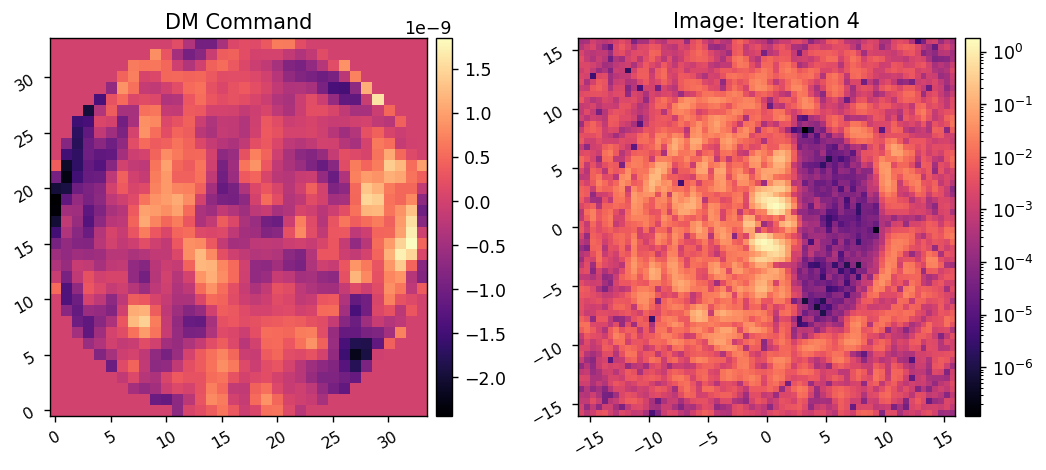

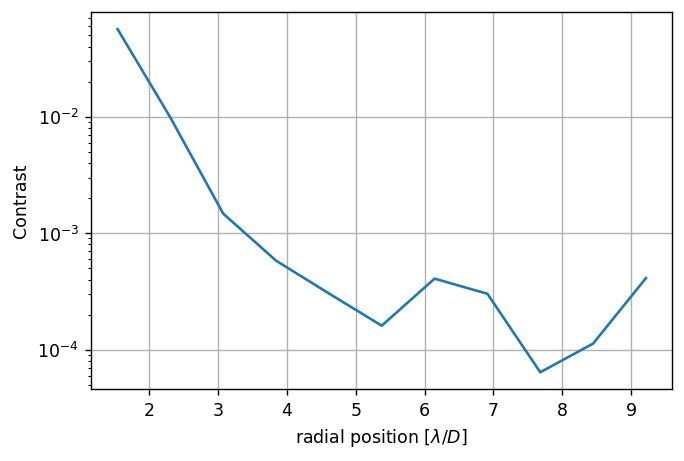

	Closed-loop iteration 5 / 20


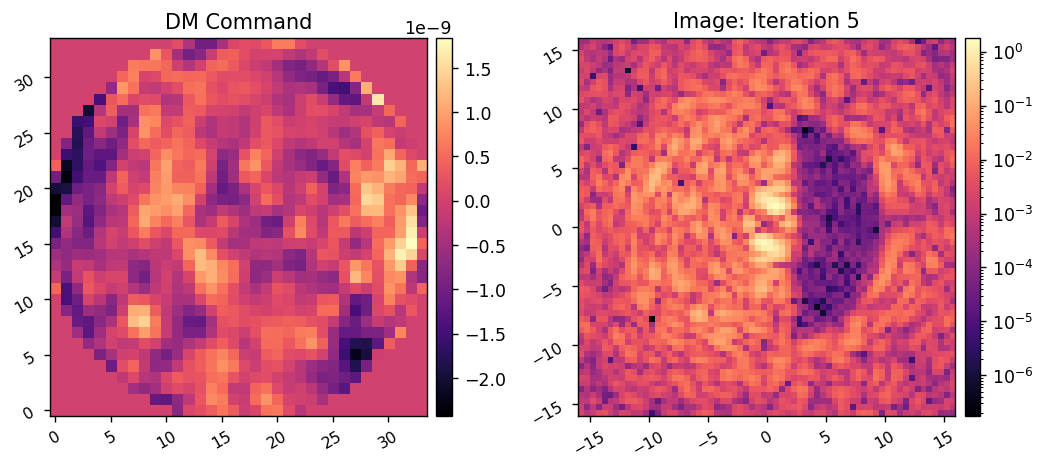

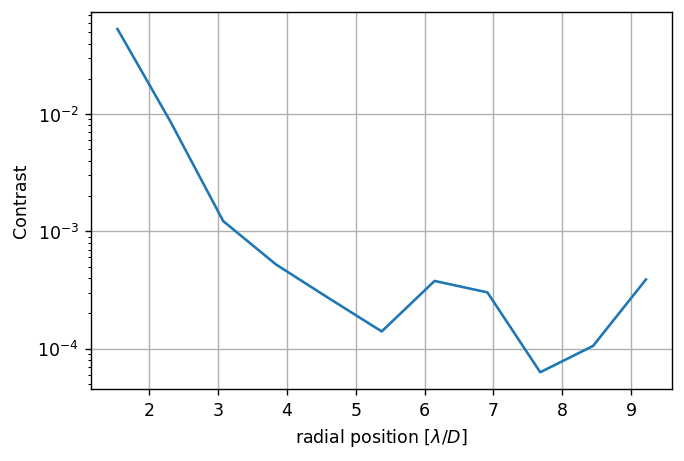

	Closed-loop iteration 6 / 20


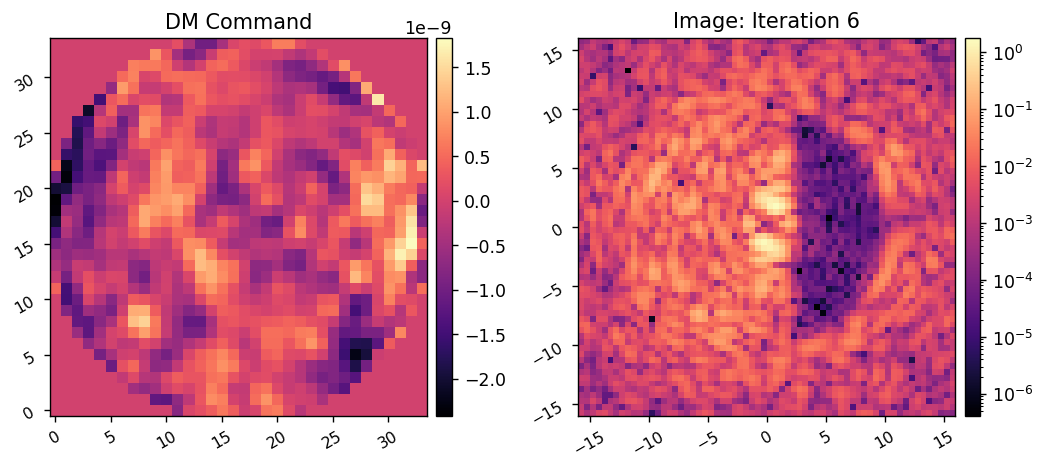

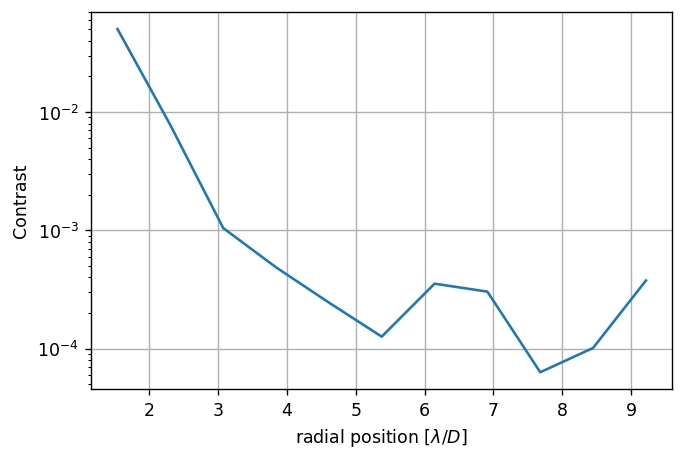

	Closed-loop iteration 7 / 20


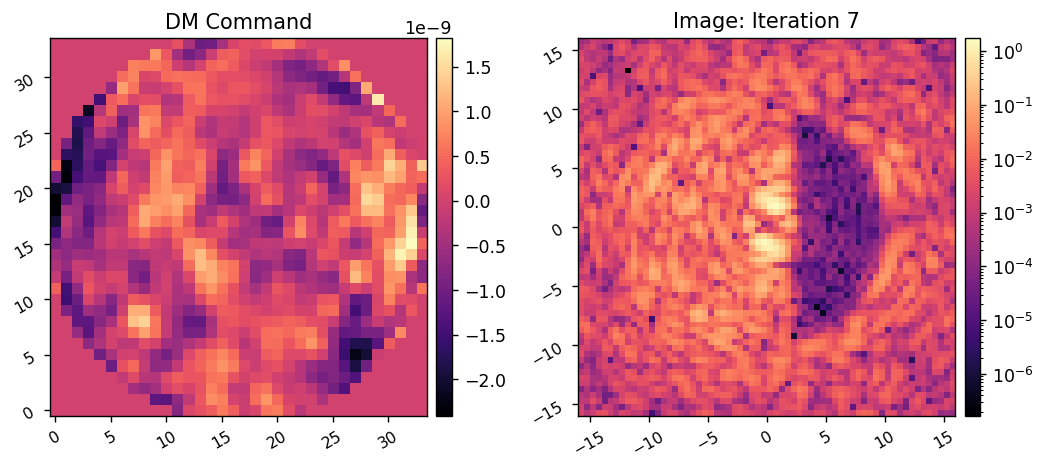

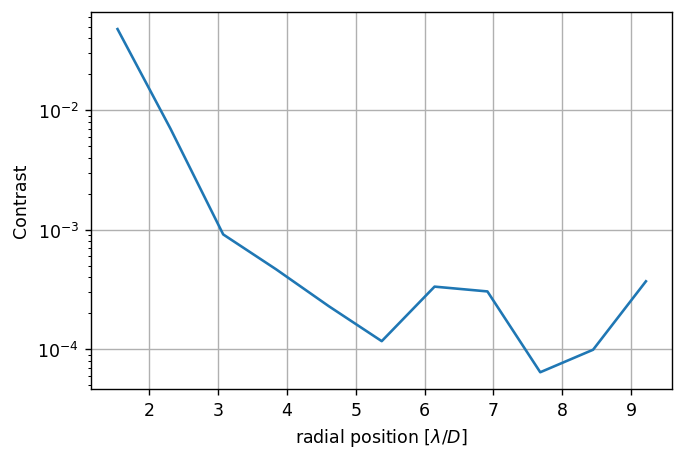

	Closed-loop iteration 8 / 20


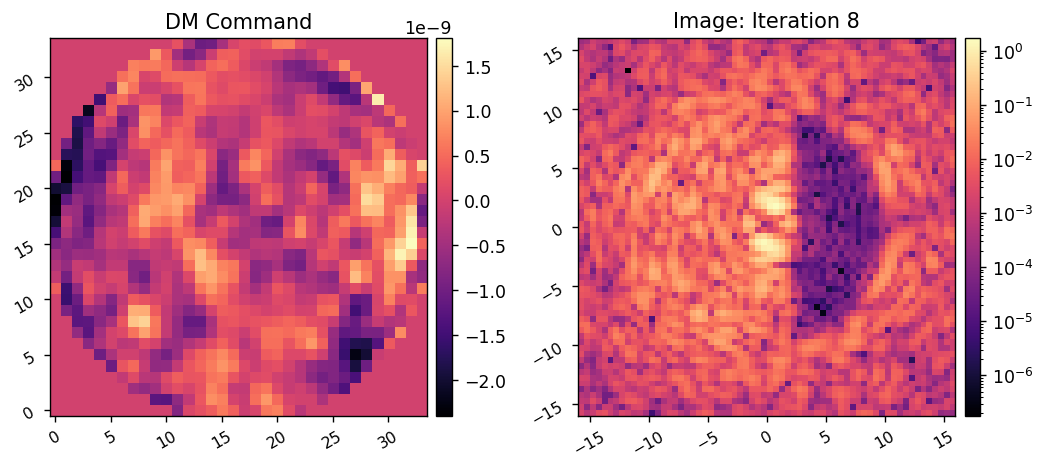

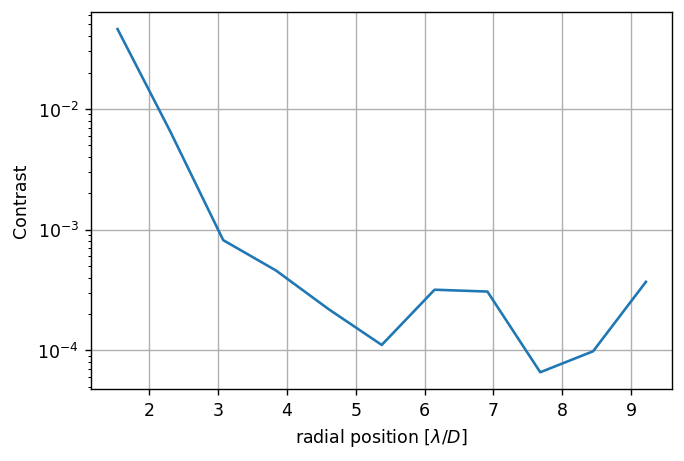

	Closed-loop iteration 9 / 20


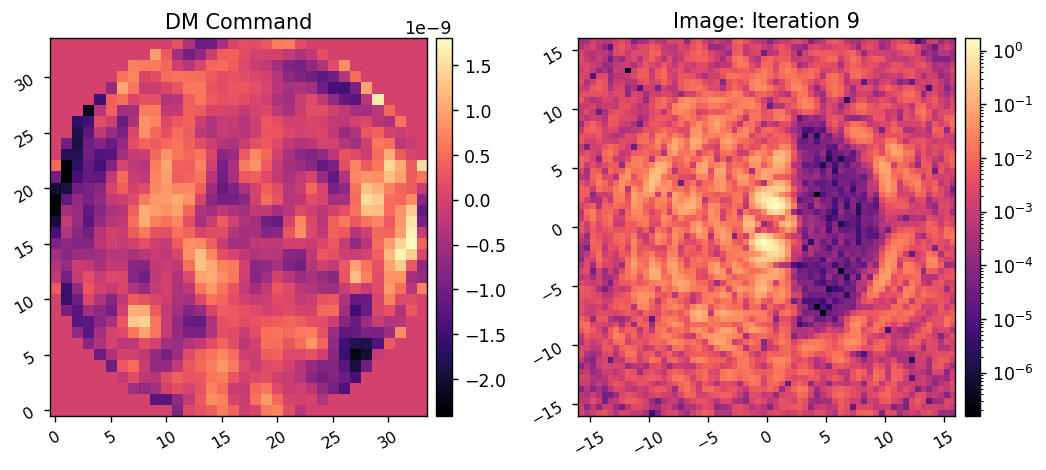

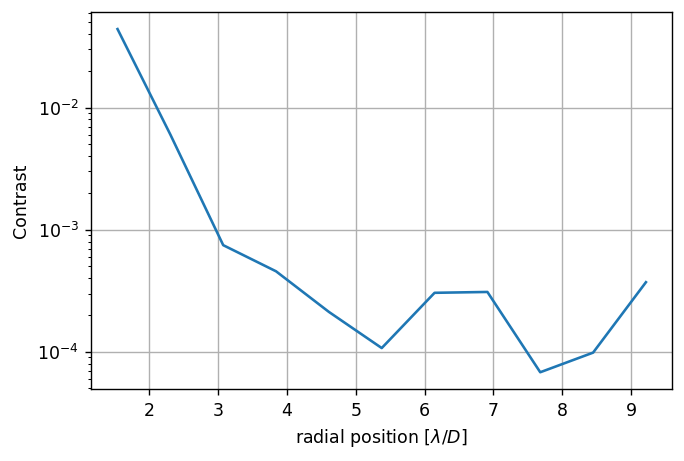

	Closed-loop iteration 10 / 20


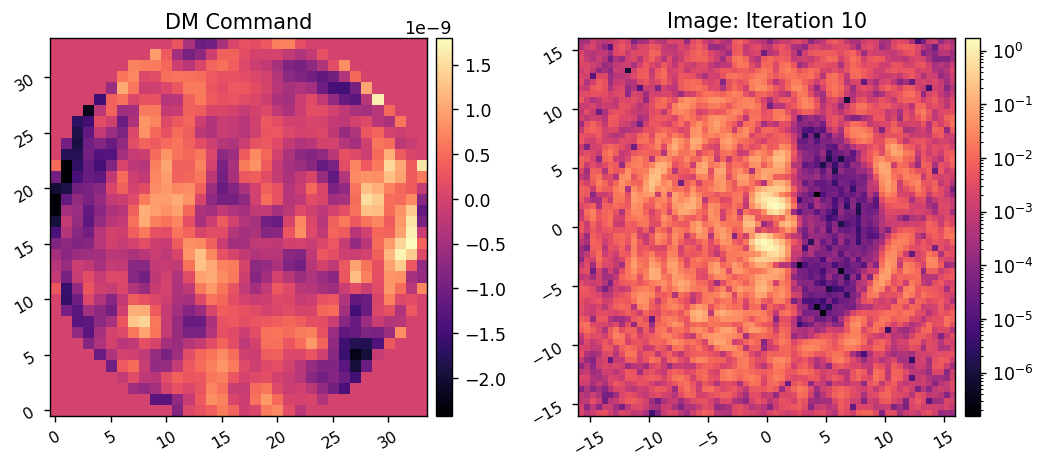

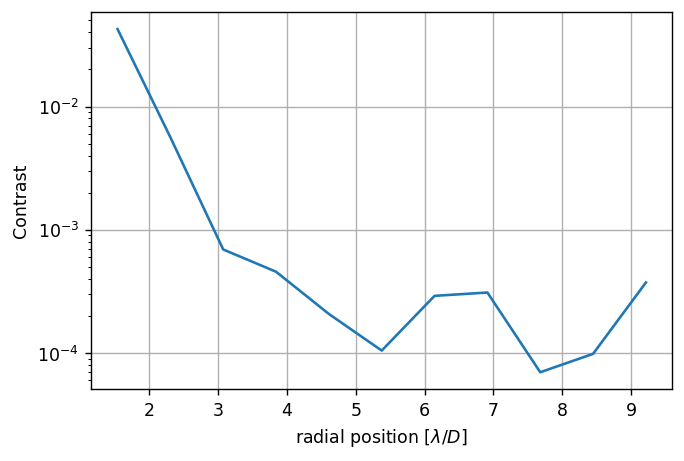

	Closed-loop iteration 11 / 20


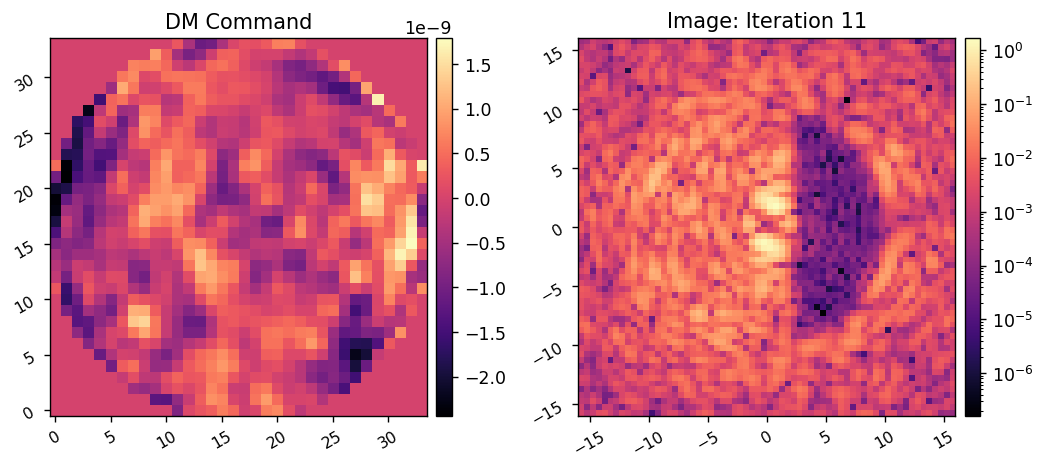

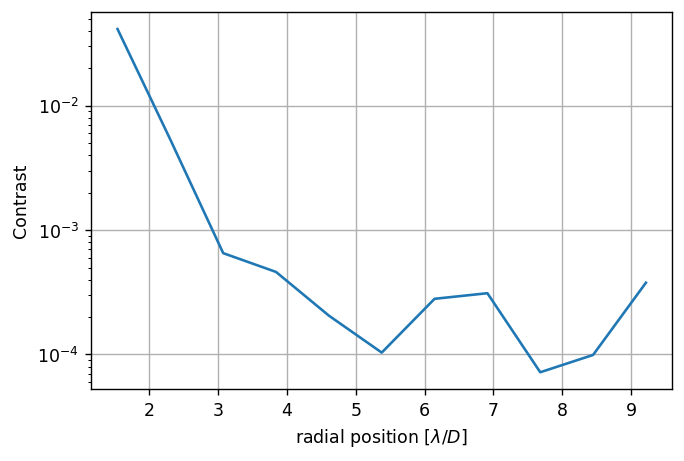

	Closed-loop iteration 12 / 20


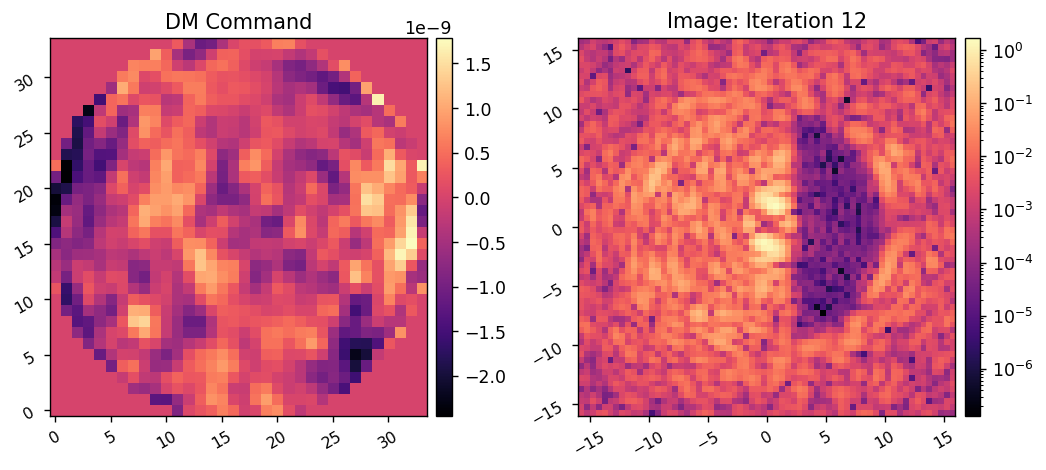

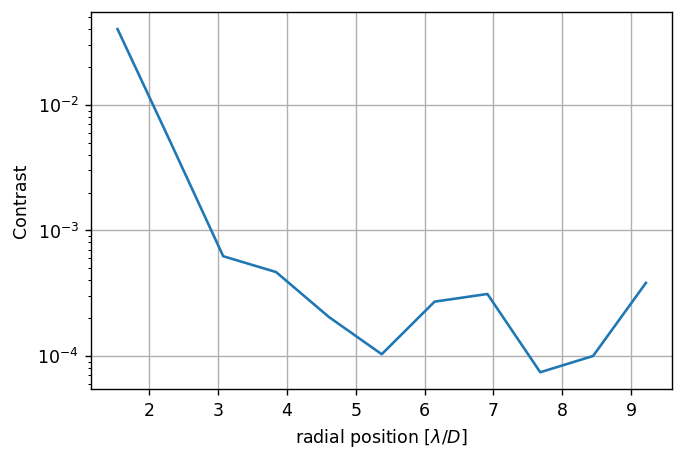

	Closed-loop iteration 13 / 20


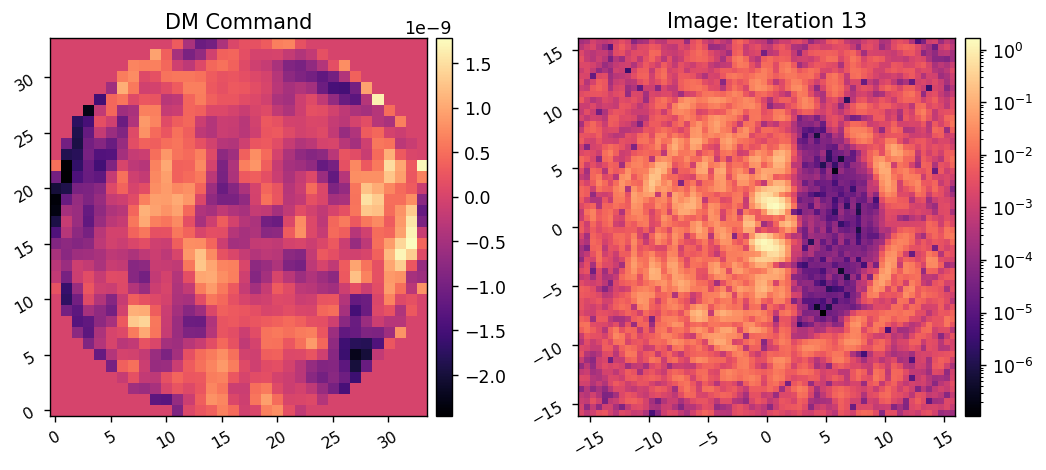

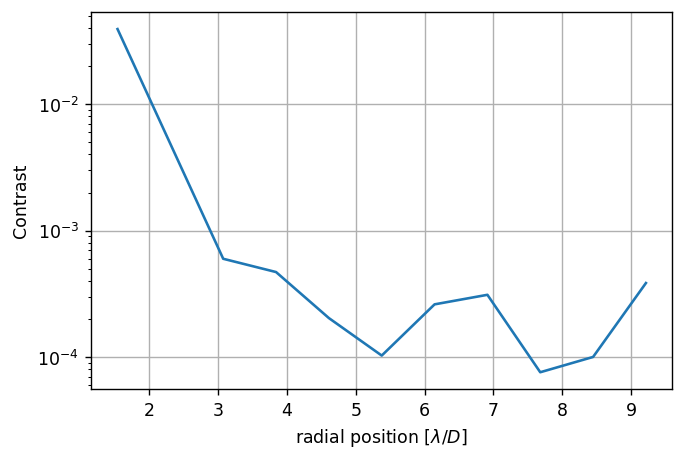

	Closed-loop iteration 14 / 20


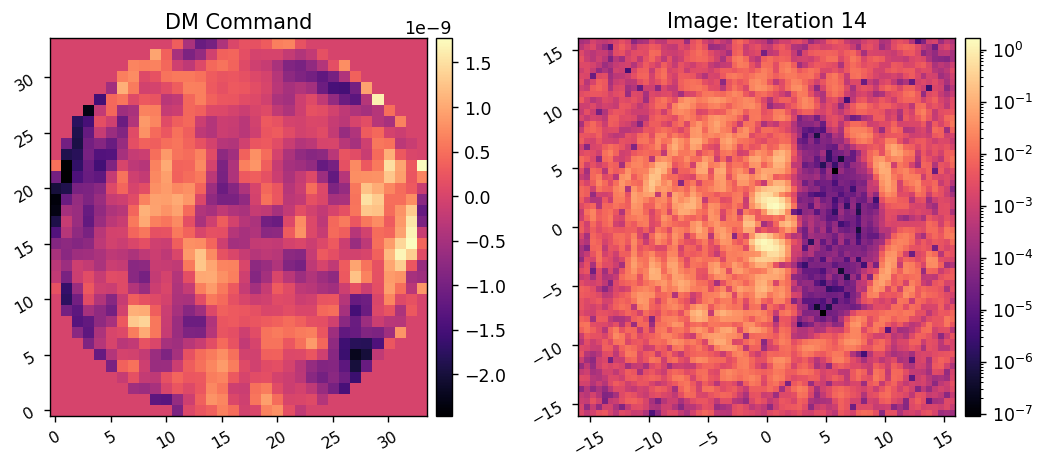

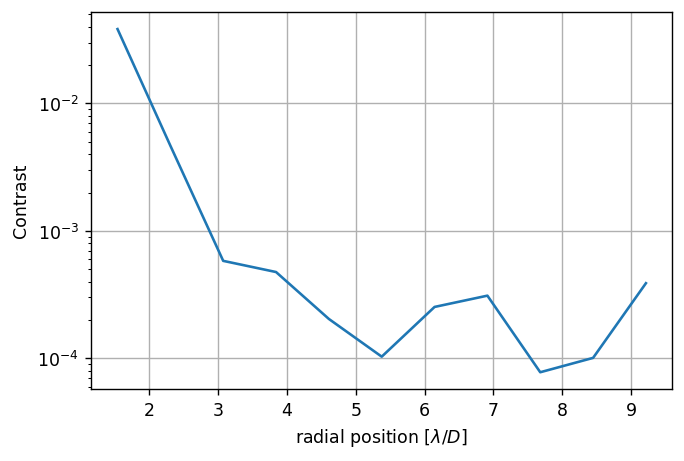

	Closed-loop iteration 15 / 20


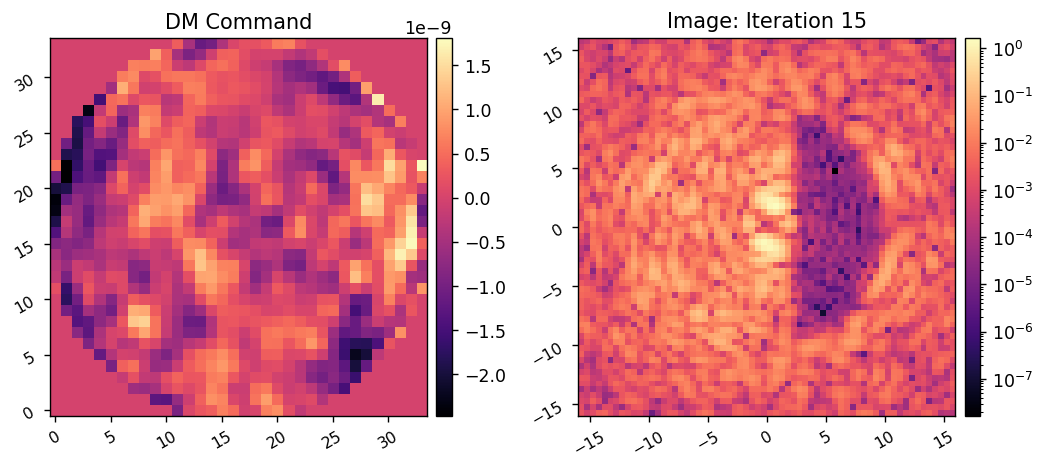

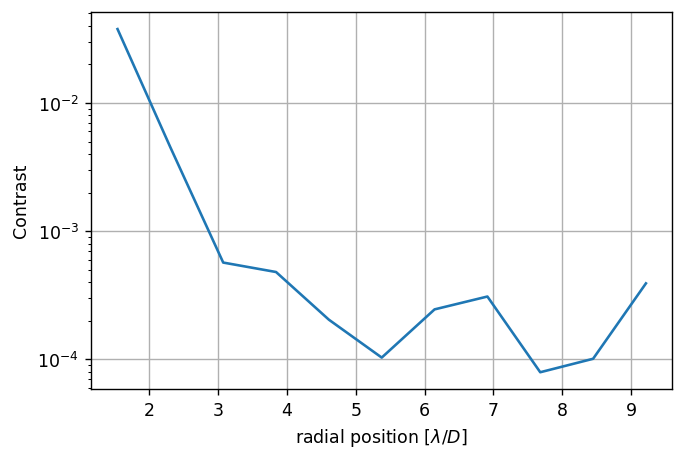

	Closed-loop iteration 16 / 20


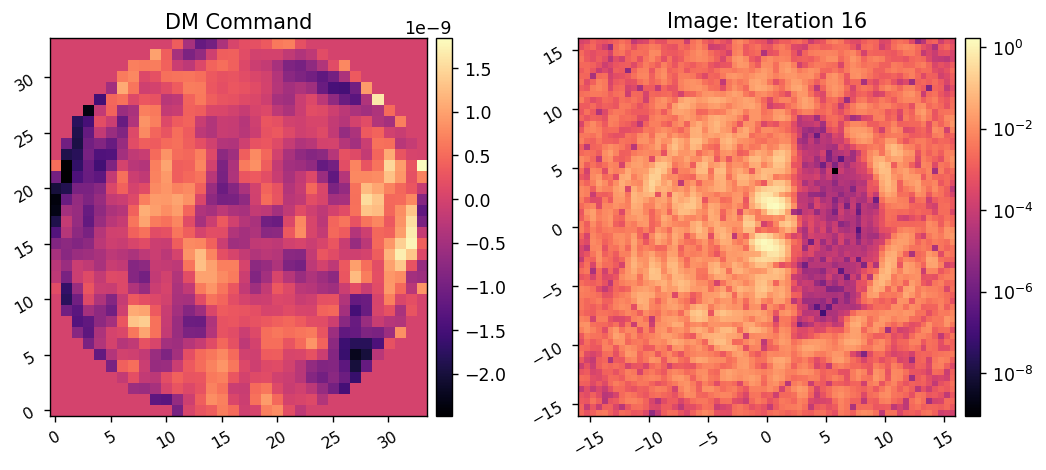

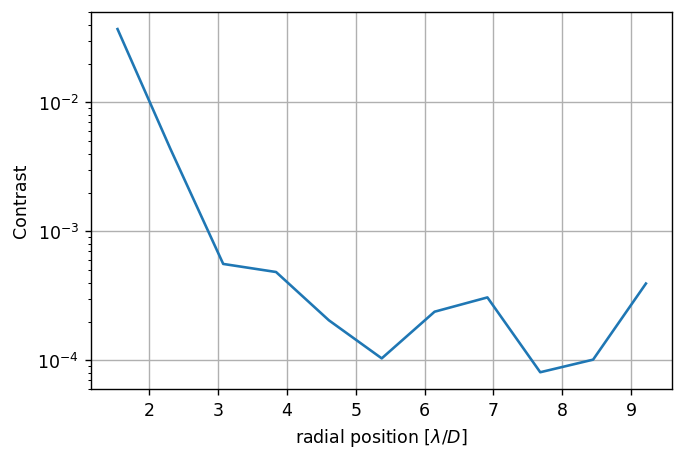

	Closed-loop iteration 17 / 20


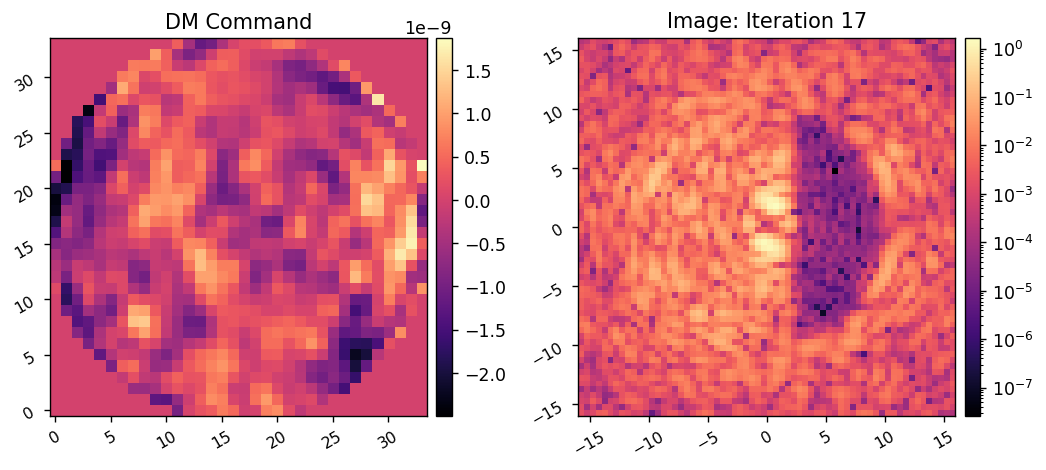

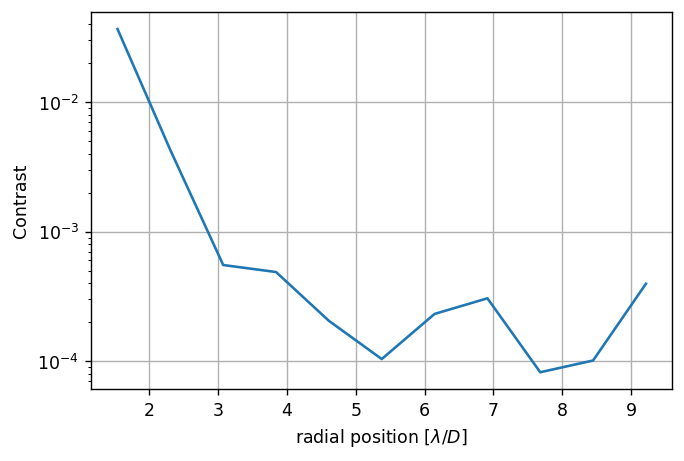

	Closed-loop iteration 18 / 20


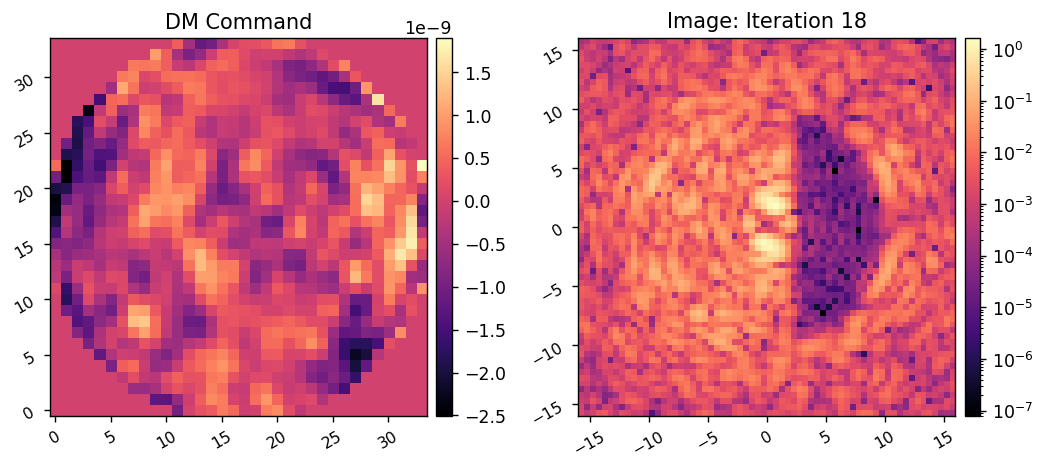

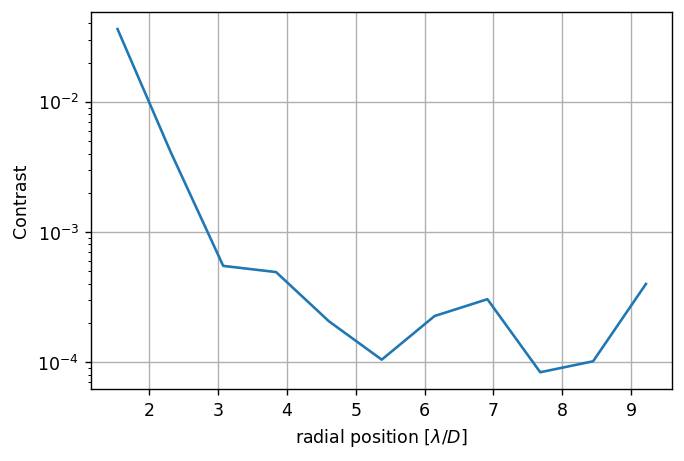

	Closed-loop iteration 19 / 20


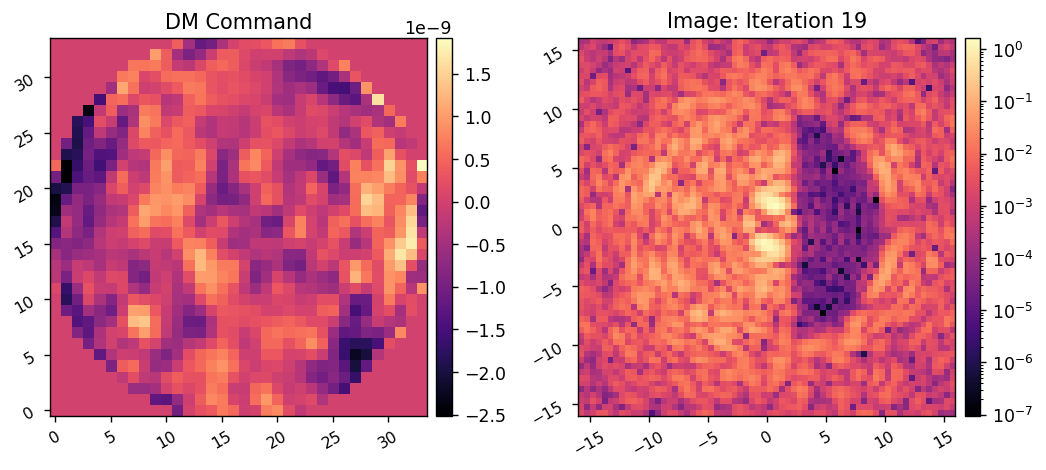

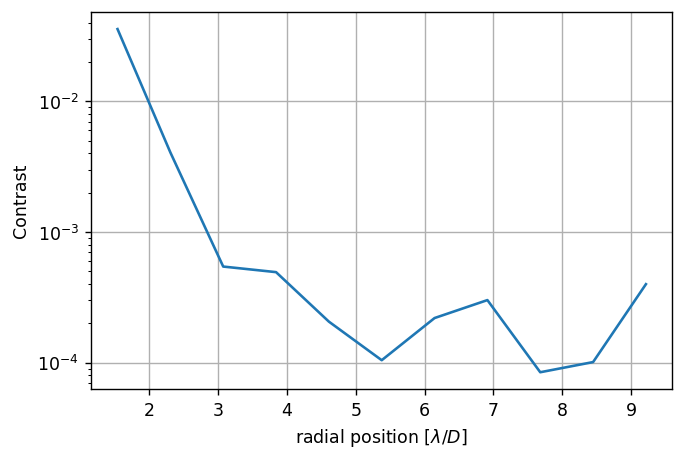

	Closed-loop iteration 20 / 20


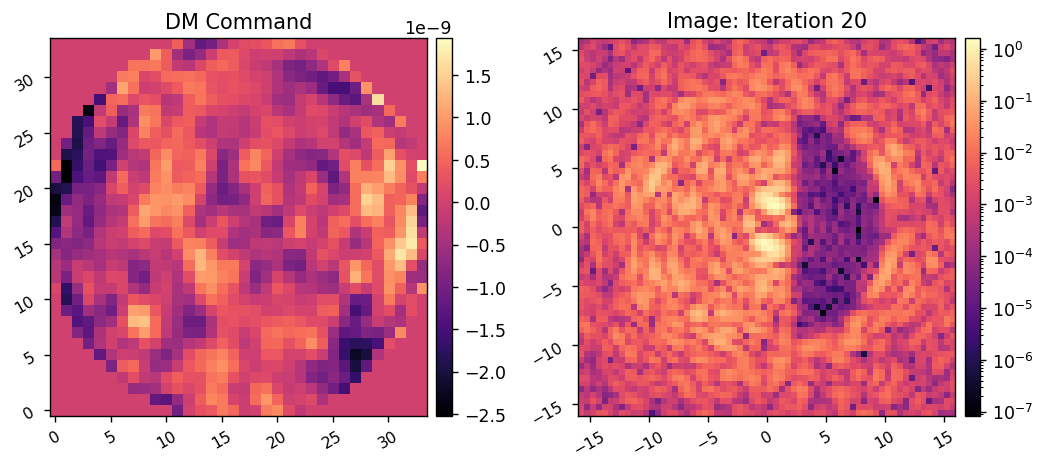

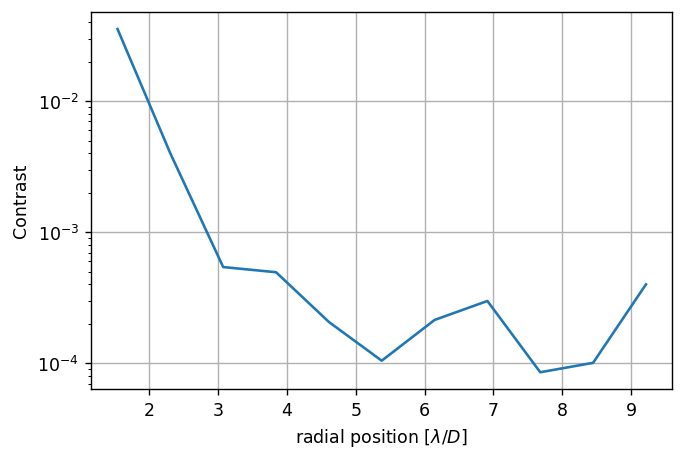

I-EFC loop completed in 35.306s.


In [15]:
reload(wfsc.iefc_1dm)
reload(wfsc.utils)

c.reset_dms()
reg_cond = 1e-2
reg_conds = [(1e-1,10), (1e-2, 20), (1e-3, 20)]

cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

for i in range(len(reg_conds)):

    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, dm_commands_1 = wfsc.iefc_1dm.run(c, 
                                              cm_wls,
                                              probe_modes, 
                                              probe_amp, 
                                              calib_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )